In [1]:
import torch
import torch.nn as nn
import time
import argparse

import os
import datetime

from torch.distributions.categorical import Categorical

# visualization 
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

device = torch.device("cpu"); gpu_id = -1 # select CPU

#gpu_id = '0' # select a single GPU  
#gpu_id = '2,3' # select multiple GPUs  
#os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)  
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU name: {:s}, gpu_id: {:s}'.format(torch.cuda.get_device_name(0),gpu_id))   
    
print(device)
print('pytorch version = ',torch.__version__)

cpu
pytorch version =  1.10.0


In [2]:
import math
import numpy as np
import torch.nn.functional as F
import random
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
class TransEncoderNet(nn.Module):
    """
    Encoder network based on self-attention transformer
    Inputs :  
      h of size      (bsz, nb_nodes, dim_emb)    batch of input cities
    Outputs :  
      h of size      (bsz, nb_nodes, dim_emb)    batch of encoded cities
      score of size  (bsz, nb_nodes, nb_nodes+1) batch of attention scores
    """
    
    def __init__(self, nb_layers, dim_emb, nb_heads, dim_ff, batchnorm):
        super(TransEncoderNet, self).__init__()
        assert dim_emb == nb_heads* (dim_emb//nb_heads) # check if dim_emb is divisible by nb_heads
        self.MHA_layers = nn.ModuleList( [nn.MultiheadAttention(dim_emb, nb_heads) for _ in range(nb_layers)] )
        self.linear1_layers = nn.ModuleList( [nn.Linear(dim_emb, dim_ff) for _ in range(nb_layers)] )
        self.linear2_layers = nn.ModuleList( [nn.Linear(dim_ff, dim_emb) for _ in range(nb_layers)] )   
        if batchnorm:
            self.norm1_layers = nn.ModuleList( [nn.BatchNorm1d(dim_emb) for _ in range(nb_layers)] )
            self.norm2_layers = nn.ModuleList( [nn.BatchNorm1d(dim_emb) for _ in range(nb_layers)] )
        else:
            self.norm1_layers = nn.ModuleList( [nn.LayerNorm(dim_emb) for _ in range(nb_layers)] )
            self.norm2_layers = nn.ModuleList( [nn.LayerNorm(dim_emb) for _ in range(nb_layers)] )
        self.nb_layers = nb_layers
        self.nb_heads = nb_heads
        self.batchnorm = batchnorm
        
    def forward(self, h):      
        # PyTorch nn.MultiheadAttention requires input size (seq_len, bsz, dim_emb) 
        h = h.transpose(0,1) # size(h)=(nb_nodes, bsz, dim_emb)  
        # L layers
        for i in range(self.nb_layers):
            h_rc = h # residual connection, size(h_rc)=(nb_nodes, bsz, dim_emb)
            h, score = self.MHA_layers[i](h, h, h) # size(h)=(nb_nodes, bsz, dim_emb), size(score)=(bsz, nb_nodes, nb_nodes)
            # add residual connection
            
            h = h_rc + h # size(h)=(nb_nodes, bsz, dim_emb)
            if self.batchnorm:
                # Pytorch nn.BatchNorm1d requires input size (bsz, dim, seq_len)
                h = h.permute(1,2,0).contiguous() # size(h)=(bsz, dim_emb, nb_nodes)
                h = self.norm1_layers[i](h)       # size(h)=(bsz, dim_emb, nb_nodes)
                h = h.permute(2,0,1).contiguous() # size(h)=(nb_nodes, bsz, dim_emb)
            else:
                h = self.norm1_layers[i](h)       # size(h)=(nb_nodes, bsz, dim_emb) 
            # feedforward
            h_rc = h # residual connection
            h = self.linear2_layers[i](torch.relu(self.linear1_layers[i](h)))
            h = h_rc + h # size(h)=(nb_nodes, bsz, dim_emb)
            if self.batchnorm:
                h = h.permute(1,2,0).contiguous() # size(h)=(bsz, dim_emb, nb_nodes)
                h = self.norm2_layers[i](h)       # size(h)=(bsz, dim_emb, nb_nodes)
                h = h.permute(2,0,1).contiguous() # size(h)=(nb_nodes, bsz, dim_emb)
            else:
                h = self.norm2_layers[i](h) # size(h)=(nb_nodes, bsz, dim_emb)
        # Transpose h
        h = h.transpose(0,1) # size(h)=(bsz, nb_nodes, dim_emb)
        return h, score
    

class Attention(nn.Module):
    def __init__(self, n_hidden):
        super(Attention, self).__init__()
        self.size = 0
        self.batch_size = 0
        self.dim = n_hidden
        
        v  = torch.FloatTensor(n_hidden)
        self.v  = nn.Parameter(v)
        self.v.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        
        # parameters for pointer attention
        self.Wref = nn.Linear(n_hidden, n_hidden)
        self.Wq = nn.Linear(n_hidden, n_hidden)
    
    
    def forward(self, q, ref):       # query and reference
        self.batch_size = q.size(0)
        self.size = int(ref.size(0) / self.batch_size)
        q = self.Wq(q)     # (B, dim)
        ref = self.Wref(ref)
        ref = ref.view(self.batch_size, self.size, self.dim)  # (B, size, dim)
        
        q_ex = q.unsqueeze(1).repeat(1, self.size, 1) # (B, size, dim)
        # v_view: (B, dim, 1)
        v_view = self.v.unsqueeze(0).expand(self.batch_size, self.dim).unsqueeze(2)
        
        # (B, size, dim) * (B, dim, 1)
        u = torch.bmm(torch.tanh(q_ex + ref), v_view).squeeze(2)
        
        return u, ref
    
class LSTM(nn.Module):
    def __init__(self, n_hidden):
        super(LSTM, self).__init__()
        
        # parameters for input gate
        self.Wxi = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whi = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wci = nn.Linear(n_hidden, n_hidden)    # w(ct)
        
        # parameters for forget gate
        self.Wxf = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whf = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wcf = nn.Linear(n_hidden, n_hidden)    # w(ct)
        
        # parameters for cell gate
        self.Wxc = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Whc = nn.Linear(n_hidden, n_hidden)    # W(ht)
        
        # parameters for forget gate
        self.Wxo = nn.Linear(n_hidden, n_hidden)    # W(xt)
        self.Who = nn.Linear(n_hidden, n_hidden)    # W(ht)
        self.wco = nn.Linear(n_hidden, n_hidden)    # w(ct)
    
    
    def forward(self, x, h, c):       # query and reference
        
        # input gate
        i = torch.sigmoid(self.Wxi(x) + self.Whi(h) + self.wci(c))
        # forget gate
        f = torch.sigmoid(self.Wxf(x) + self.Whf(h) + self.wcf(c))
        # cell gate
        c = f * c + i * torch.tanh(self.Wxc(x) + self.Whc(h))
        # output gate
        o = torch.sigmoid(self.Wxo(x) + self.Who(h) + self.wco(c))
        
        h = o * torch.tanh(c)
        
        return h, c

class HPN(nn.Module):
    def __init__(self, n_feature, n_hidden):

        super(HPN, self).__init__()
        self.city_size = 0
        self.batch_size = 0
        self.dim = n_hidden
        
        # lstm for first turn
        #self.lstm0 = nn.LSTM(n_hidden, n_hidden)main_training - Jupyter Notebook
        
        # pointer layer
        self.pointer = Attention(n_hidden)
        self.TransPointer = Attention(n_hidden)
        
        # lstm encoder
        self.encoder = LSTM(n_hidden)
        
        # trainable first hidden input
        h0 = torch.FloatTensor(n_hidden)
        c0 = torch.FloatTensor(n_hidden)
        # trainable latent variable coefficient
        print('here') 
        alpha = torch.ones(1)
        self.h0 = nn.Parameter(h0)
        self.c0 = nn.Parameter(c0)
        
        self.alpha = nn.Parameter(alpha)
        self.h0.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        self.c0.data.uniform_(-1/math.sqrt(n_hidden), 1/math.sqrt(n_hidden))
        
        r1 = torch.ones(1)
        r2 = torch.ones(1)
        r3 = torch.ones(1)
        self.r1 = nn.Parameter(r1)
        self.r2 = nn.Parameter(r2)
        self.r3 = nn.Parameter(r3)
        
        # embedding
        self.embedding_x = nn.Linear(n_feature, n_hidden)
        self.embedding_all = nn.Linear(n_feature, n_hidden)
        self.Transembedding_all = TransEncoderNet(6, 128, 8, 512, batchnorm=True)#6,128,8,512
        
        # vector to start decoding 
        self.start_placeholder = nn.Parameter(torch.randn(n_hidden))
        
        # weights for GNN
        self.W1 = nn.Linear(n_hidden, n_hidden)
        self.W2 = nn.Linear(n_hidden, n_hidden)
        self.W3 = nn.Linear(n_hidden, n_hidden)
        
        # aggregation function for GNN
        self.agg_1 = nn.Linear(n_hidden, n_hidden)
        self.agg_2 = nn.Linear(n_hidden, n_hidden)
        self.agg_3 = nn.Linear(n_hidden, n_hidden)
    
    
    def forward(self,context,Transcontext, x, X_all, mask, h=None, c=None, latent=None):
        '''
        Inputs (B: batch size, size: city size, dim: hidden dimension)
        
        x: current city coordinate (B, 2)
        X_all: all cities' cooridnates (B, size, 2)
        mask: mask visited cities
        h: hidden variable (B, dim)
        c: cell gate (B, dim)
        latent: latent pointer vector from previous layer (B, size, dim)
        
        Outputs
        
        softmax: probability distribution of next city (B, size)
        h: hidden variable (B, dim)
        c: cell gate (B, dim)
        latent_u: latent pointer vector for next layer
        '''
        
        self.batch_size = X_all.size(0)
        self.city_size = X_all.size(1)
        
        # Check if this the first iteration loop
        if h is None or c is None:
            x          = self.start_placeholder  
            context = self.embedding_all(X_all)
            Transcontext,_ = self.Transembedding_all(context)
            
            # =============================
            # graph neural network encoder
            # =============================

            # (B, size, dim)
            Central_context = Central_context.reshape(-1, self.dim)
            Transcontext = Transcontext.reshape(-1, self.dim)

            Central_context = self.r1 * self.W1(Central_context)\
                + (1-self.r1) * F.relu(self.agg_1(Central_context/(self.city_size-1)))

            Central_context = self.r2 * self.W2(Central_context)\
                + (1-self.r2) * F.relu(self.agg_2(Central_context/(self.city_size-1)))

            Central_context = self.r3 * self.W3(Central_context)\
                + (1-self.r3) * F.relu(self.agg_3(Central_context/(self.city_size-1)))
            h0 = self.h0.unsqueeze(0).expand(self.batch_size, self.dim)
            c0 = self.c0.unsqueeze(0).expand(self.batch_size, self.dim)

            h0 = h0.unsqueeze(0).contiguous()
            c0 = c0.unsqueeze(0).contiguous()
            
            # let h0, c0 be the hidden variable of first turn
            h = h0.squeeze(0)
            c = c0.squeeze(0)
        else:
            x          = self.embedding_x(x)
        # LSTM encoder1900/2500
        h, c = self.encoder(x, h, c)
        # query vector
        q = h
        # pointer
        u1, _ = self.pointer(q, Central_context)
        u2 ,_ = self.TransPointer(q, Transcontext)
        # Avg Agg between the two attention vector
        u = torch.maximum(u1,u2)
        latent_u = u.clone()
                
        u = 10 * torch.tanh(u) + mask + mask_temp
        return Central_context, Transcontext,F.softmax(u, dim=1), h, c, latent_u
# params= list(HPN(n_feature = 2, n_hidden = 128).parameters())
# print(len(params))
# for name,parameters in HPN(n_feature = 2, n_hidden = 128).named_parameters():
#     print(name,':',parameters.size())

# daniel rectangle feature handle

In [3]:
'''
This part I designed the rectangle-characterized TSP, that means for every step the agent walk through a corner,
then he travel through the whole rectangle using zig-zag, finally he ends up at one of the rest corners of 
the rextangle, so, it equals the agent walk through three points at one step, in practice, I add three points into 
mask to make them unselectable.
'''
def rectangle_process(f_temp,idx,Y,Y0,mask,k,B):
    Y1 = Y[zero_to_bsz, idx.data].clone()
    rectangle_inf = idx/4
    feature_table = f_temp.outcorner_getout(rectangle_inf,B)
    feature_table = torch.Tensor(feature_table).type(torch.long)
    Y_corner = Y[zero_to_bsz, feature_table[:,0].data].clone()
    if k ==0:
        reward = 0
    if k > 0:
        reward = torch.sum((Y1 - Y0)**2 , dim=1 )**0.5
        reward += torch.sum((Y_corner - Y1)**2 , dim=1 )**0.5
        #dis = (Y1 - Y0)**2
        #dis_1 = (Y_corner - Y1)**2
        #reward = torch.maximum(dis[:,0],dis[:,1])**0.5
        #reward += torch.maximum(dis_1[:,0],dis_1[:,1])**0.5  
    mask[zero_to_bsz, idx.data] += -np.inf
    #這邊是全都是四邊形時的配置
    mask[zero_to_bsz, feature_table[:,0].data] += -np.inf
    mask[zero_to_bsz, feature_table[:,1].data] += -np.inf    
    mask[zero_to_bsz, feature_table[:,2].data] += -np.inf 
    return reward, Y_corner, Y_corner
def rectangle_process_actor(f_temp,idx,Y,Y0,mask,k,B,i,path_gazebo,Not_choosen_ones,Not_last_time):
    Y1 = Y[zero_to_bsz, idx.data].clone()
    rectangle_inf = idx/4
    feature_table = f_temp.outcorner_getout(rectangle_inf,B)
    feature_table = torch.Tensor(feature_table).type(torch.long)
    Y_corner = Y[zero_to_bsz, feature_table[:,0].data].clone()
    if i % 100 == 0:
        path_gazebo.append([idx.data[0].tolist(),feature_table[:,0].data[0].tolist()])
    if k ==0:
        reward = 0
    if k > 0:
        reward = torch.sum((Y1 - Y0)**2 , dim=1 )**0.5
        reward += torch.sum((Y_corner - Y1)**2 , dim=1 )**0.5
        #dis = (Y1 - Y0)**2
        #dis_1 = (Y_corner - Y1)**2
        #reward = torch.maximum(dis[:,0],dis[:,1])**0.5
        #reward += torch.maximum(dis_1[:,0],dis_1[:,1])**0.5  
    mask[zero_to_bsz, idx.data] += -np.inf
    mask[zero_to_bsz, feature_table[:,0].data] += -np.inf
    mask[zero_to_bsz, feature_table[:,1].data ] += -np.inf    
    mask[zero_to_bsz, feature_table[:,2].data ] += -np.inf
    if_frozen = Not_last_time[zero_to_bsz, idx.data]
    Not_choosen_ones[zero_to_bsz,if_frozen * (idx.data +4)] = 0
    if_frozen = Not_last_time[zero_to_bsz, feature_table[:,0].data]
    Not_choosen_ones[zero_to_bsz,if_frozen * (feature_table[:,0] +4)] = 0
    if_frozen = Not_last_time[zero_to_bsz, feature_table[:,1].data]
    Not_choosen_ones[zero_to_bsz,if_frozen * (feature_table[:,1] +4)] = 0  
    if_frozen = Not_last_time[zero_to_bsz, feature_table[:,2].data]
    Not_choosen_ones[zero_to_bsz,if_frozen * (feature_table[:,2] +4)] = 0
    Not_choosen_ones[zero_to_bsz,0] = 1
    return reward, Y_corner, Y_corner

In [ ]:
def unmask_checker(R, waiting_time_list, mask_temp):
    if_dried = waiting_time_list - R
    if_dried = if_dried<0
    # if a ROI is ready for re-opened, it would be True in if_dried matrix
    mask_temp[if_dried] = 0
    return mask_temp

prepare to train
Hyper parameters:
learning rate 0.0001
batch size 256
steps 500
epoch 100
here
here
epoch:0, batch:100/500, reward:5316.244140625


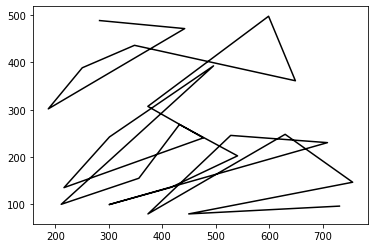

record the last path to gazebo for showing up
epoch:0, batch:200/500, reward:5197.3203125


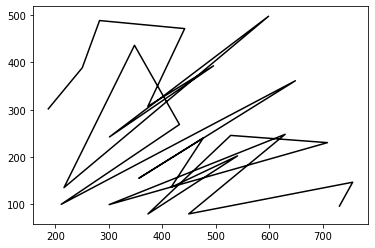

record the last path to gazebo for showing up
epoch:0, batch:300/500, reward:5184.7939453125


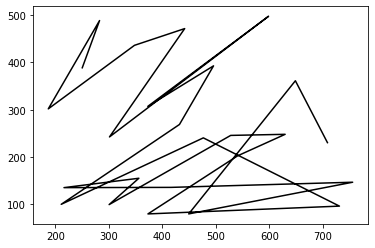

record the last path to gazebo for showing up
epoch:0, batch:400/500, reward:5206.69140625


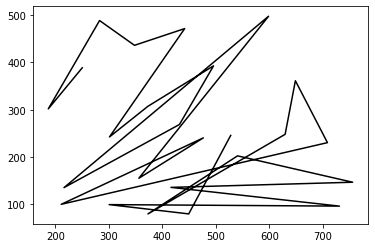

record the last path to gazebo for showing up
epoch:0, batch:500/500, reward:5176.603515625


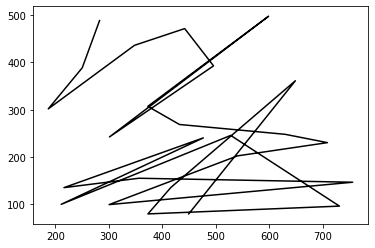

record the last path to gazebo for showing up
Avg Actor 5392.08984375 --- Avg Critic 6667.28564453125
My actor is going on the right road Hallelujah :) Updated
Epoch: 0, epoch time: 13.021min, tot time: 0.009day, L_actor: 5392.090, L_critic: 6667.286, update: True
Save Checkpoints
epoch:1, batch:100/500, reward:5086.525390625


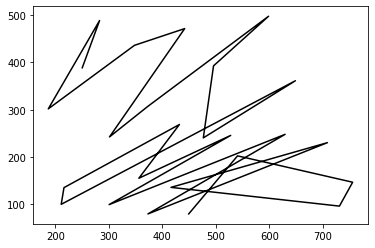

record the last path to gazebo for showing up
epoch:1, batch:200/500, reward:5180.0576171875


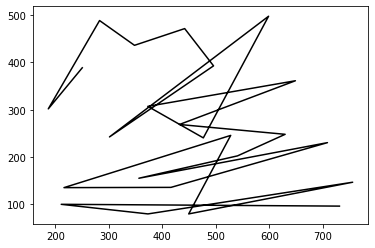

record the last path to gazebo for showing up
epoch:1, batch:300/500, reward:5076.43359375


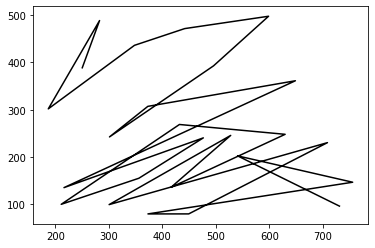

record the last path to gazebo for showing up
epoch:1, batch:400/500, reward:5053.31787109375


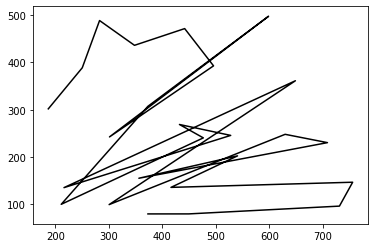

record the last path to gazebo for showing up
epoch:1, batch:500/500, reward:5110.73583984375


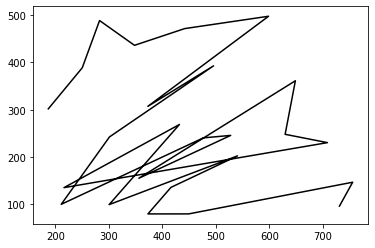

record the last path to gazebo for showing up
Avg Actor 5134.4609375 --- Avg Critic 5392.08984375
My actor is going on the right road Hallelujah :) Updated
Epoch: 1, epoch time: 13.068min, tot time: 0.018day, L_actor: 5134.461, L_critic: 5392.090, update: True
Save Checkpoints
epoch:2, batch:100/500, reward:5038.5703125


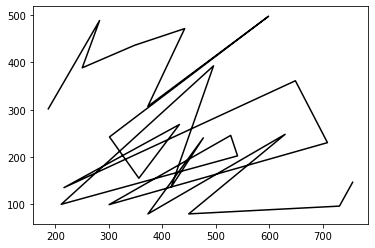

record the last path to gazebo for showing up
epoch:2, batch:200/500, reward:5097.599609375


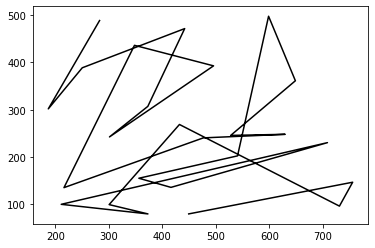

record the last path to gazebo for showing up
epoch:2, batch:300/500, reward:5046.74560546875


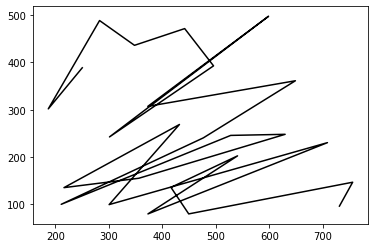

record the last path to gazebo for showing up
epoch:2, batch:400/500, reward:5089.52685546875


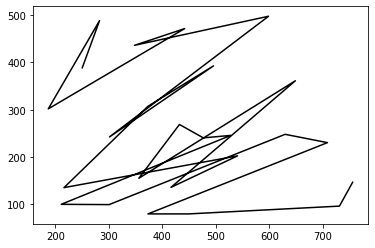

record the last path to gazebo for showing up
epoch:2, batch:500/500, reward:5149.2353515625


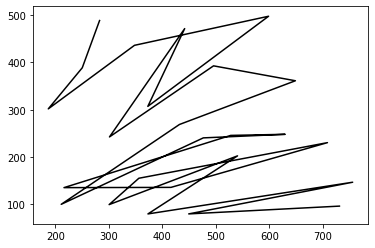

record the last path to gazebo for showing up
Avg Actor 5020.10791015625 --- Avg Critic 5134.4609375
My actor is going on the right road Hallelujah :) Updated
Epoch: 2, epoch time: 12.979min, tot time: 0.028day, L_actor: 5020.108, L_critic: 5134.461, update: True
Save Checkpoints
epoch:3, batch:100/500, reward:5076.8623046875


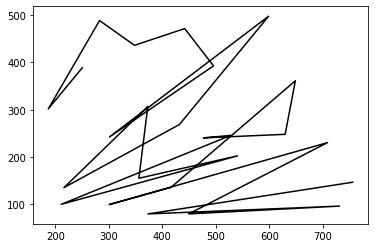

record the last path to gazebo for showing up
epoch:3, batch:200/500, reward:5094.74169921875


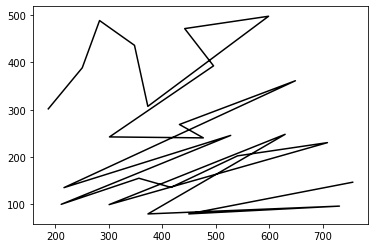

record the last path to gazebo for showing up
epoch:3, batch:300/500, reward:5075.94287109375


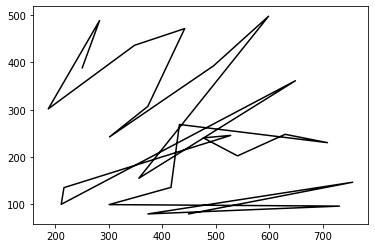

record the last path to gazebo for showing up
epoch:3, batch:400/500, reward:5090.1943359375


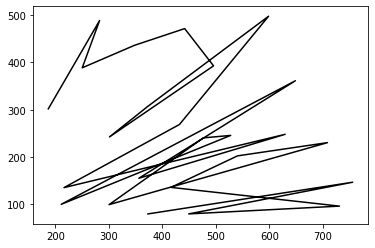

record the last path to gazebo for showing up
epoch:3, batch:500/500, reward:5060.89794921875


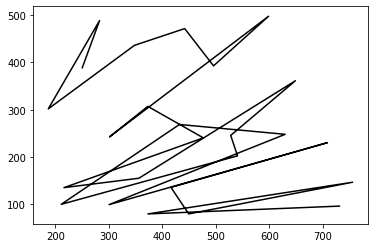

record the last path to gazebo for showing up
Avg Actor 5083.85302734375 --- Avg Critic 5020.10791015625
Epoch: 3, epoch time: 12.941min, tot time: 0.037day, L_actor: 5083.853, L_critic: 5020.108, update: False
Save Checkpoints
epoch:4, batch:100/500, reward:5102.04833984375


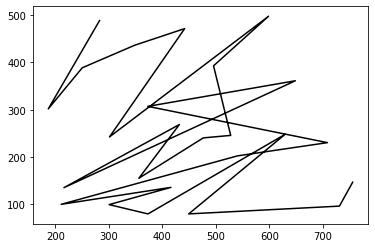

record the last path to gazebo for showing up
epoch:4, batch:200/500, reward:5118.5576171875


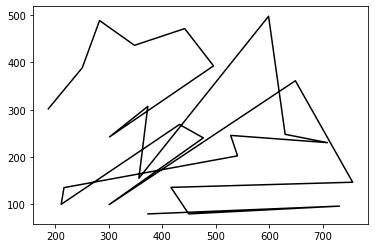

record the last path to gazebo for showing up
epoch:4, batch:300/500, reward:5042.546875


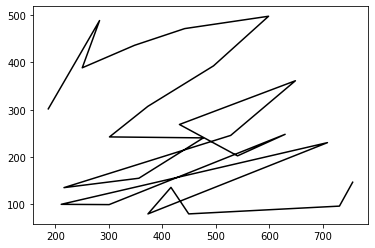

record the last path to gazebo for showing up
epoch:4, batch:400/500, reward:5035.06787109375


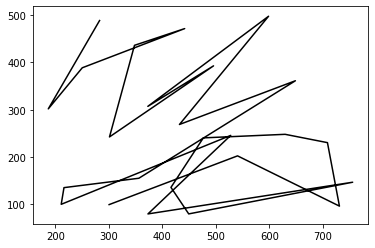

record the last path to gazebo for showing up
epoch:4, batch:500/500, reward:5097.61962890625


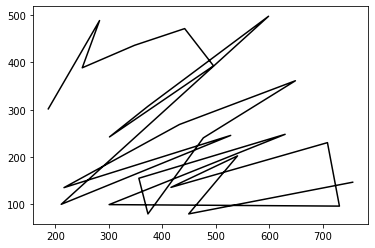

record the last path to gazebo for showing up
Avg Actor 4686.74560546875 --- Avg Critic 5020.10791015625
My actor is going on the right road Hallelujah :) Updated
Epoch: 4, epoch time: 12.937min, tot time: 0.046day, L_actor: 4686.746, L_critic: 5020.108, update: True
Save Checkpoints
epoch:5, batch:100/500, reward:5368.931640625


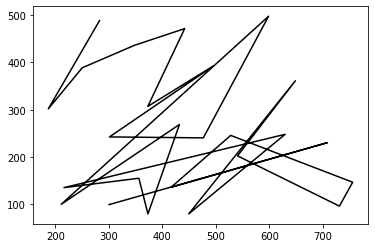

record the last path to gazebo for showing up
epoch:5, batch:200/500, reward:5121.65234375


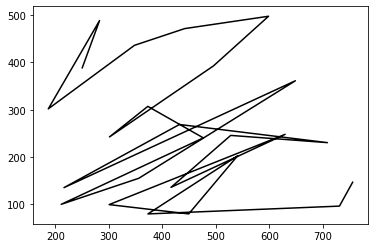

record the last path to gazebo for showing up
epoch:5, batch:300/500, reward:5072.48974609375


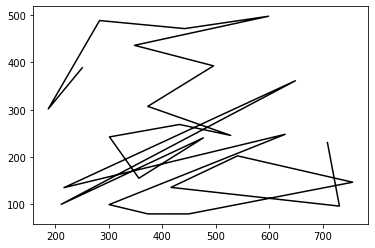

record the last path to gazebo for showing up
epoch:5, batch:400/500, reward:5149.5439453125


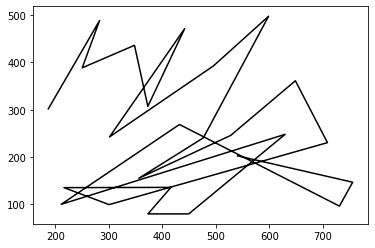

record the last path to gazebo for showing up
epoch:5, batch:500/500, reward:5201.486328125


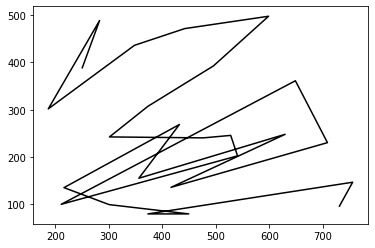

record the last path to gazebo for showing up
Avg Actor 4649.44580078125 --- Avg Critic 4686.74560546875
My actor is going on the right road Hallelujah :) Updated
Epoch: 5, epoch time: 12.941min, tot time: 0.055day, L_actor: 4649.446, L_critic: 4686.746, update: True
Save Checkpoints
epoch:6, batch:100/500, reward:5138.06982421875


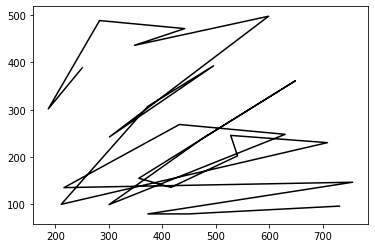

record the last path to gazebo for showing up
epoch:6, batch:200/500, reward:5067.6884765625


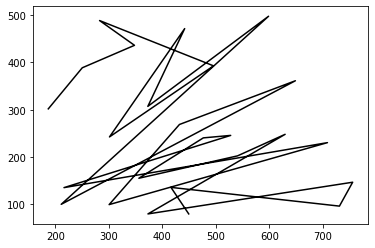

record the last path to gazebo for showing up
epoch:6, batch:300/500, reward:5199.548828125


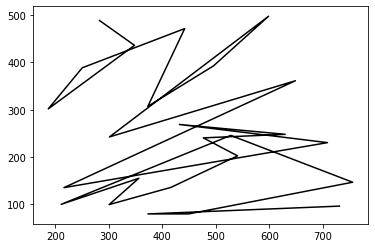

record the last path to gazebo for showing up
epoch:6, batch:400/500, reward:5209.109375


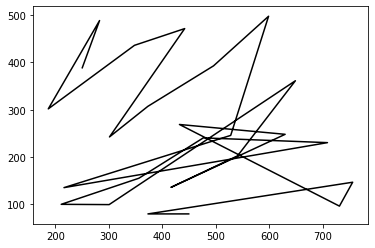

record the last path to gazebo for showing up
epoch:6, batch:500/500, reward:5198.119140625


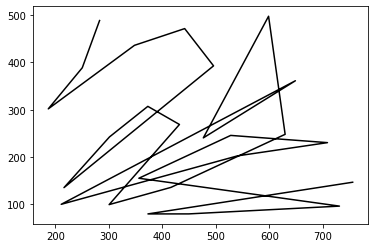

record the last path to gazebo for showing up
Avg Actor 5632.12060546875 --- Avg Critic 4649.44580078125
Epoch: 6, epoch time: 12.928min, tot time: 0.064day, L_actor: 5632.121, L_critic: 4649.446, update: False
Save Checkpoints
epoch:7, batch:100/500, reward:5177.208984375


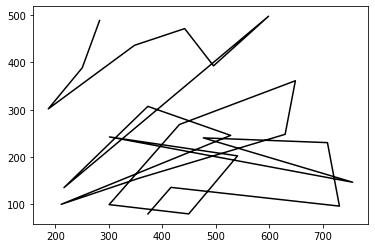

record the last path to gazebo for showing up
epoch:7, batch:200/500, reward:5124.4560546875


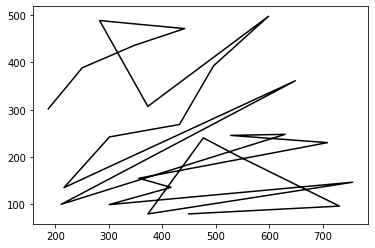

record the last path to gazebo for showing up
epoch:7, batch:300/500, reward:5107.34521484375


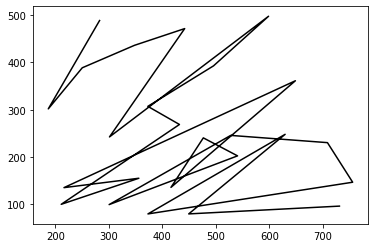

record the last path to gazebo for showing up
epoch:7, batch:400/500, reward:5094.21142578125


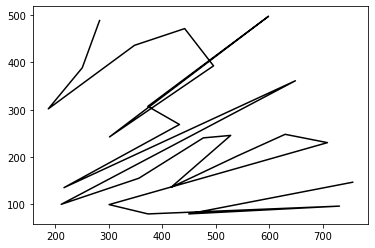

record the last path to gazebo for showing up
epoch:7, batch:500/500, reward:5128.12744140625


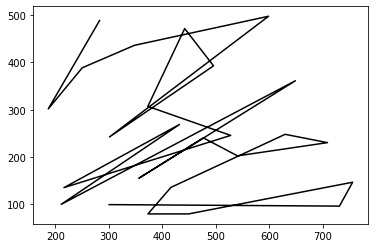

record the last path to gazebo for showing up
Avg Actor 5661.00439453125 --- Avg Critic 4649.44580078125
Epoch: 7, epoch time: 12.928min, tot time: 0.074day, L_actor: 5661.004, L_critic: 4649.446, update: False
Save Checkpoints
epoch:8, batch:100/500, reward:5174.69091796875


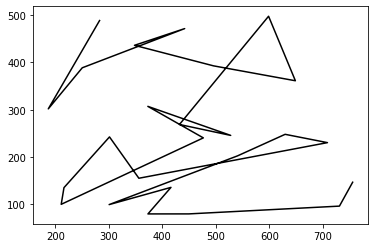

record the last path to gazebo for showing up
epoch:8, batch:200/500, reward:5153.12841796875


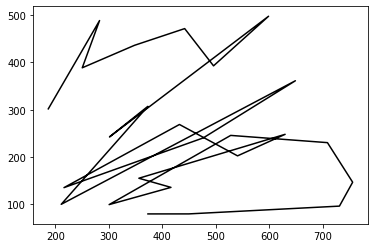

record the last path to gazebo for showing up
epoch:8, batch:300/500, reward:5101.8857421875


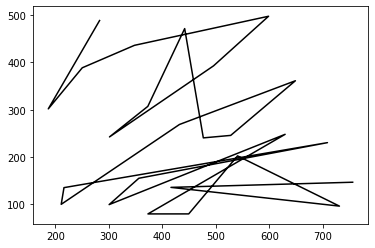

record the last path to gazebo for showing up
epoch:8, batch:400/500, reward:5062.68505859375


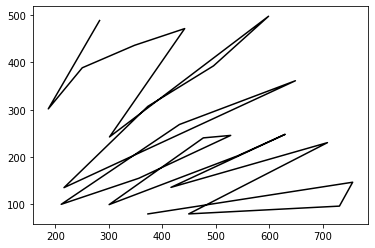

record the last path to gazebo for showing up
epoch:8, batch:500/500, reward:5087.6064453125


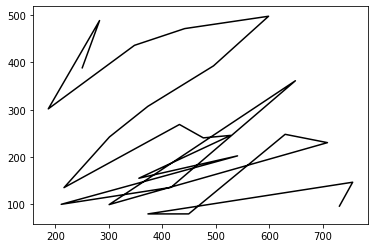

record the last path to gazebo for showing up
Avg Actor 5632.22607421875 --- Avg Critic 4649.44580078125
Epoch: 8, epoch time: 12.922min, tot time: 0.083day, L_actor: 5632.226, L_critic: 4649.446, update: False
Save Checkpoints
epoch:9, batch:100/500, reward:5074.29638671875


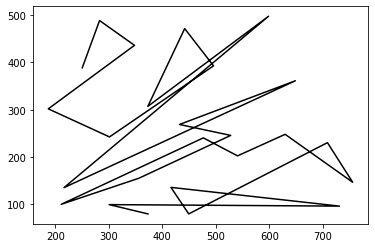

record the last path to gazebo for showing up
epoch:9, batch:200/500, reward:5101.55810546875


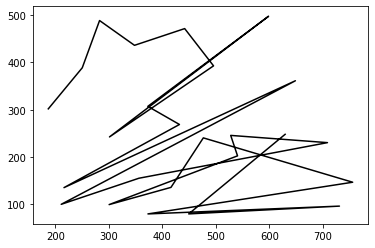

record the last path to gazebo for showing up
epoch:9, batch:300/500, reward:5103.68505859375


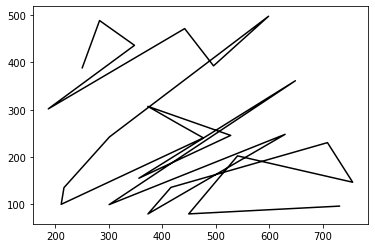

record the last path to gazebo for showing up
epoch:9, batch:400/500, reward:5073.71337890625


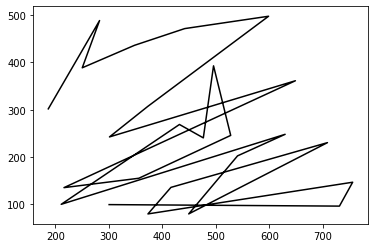

record the last path to gazebo for showing up
epoch:9, batch:500/500, reward:5095.24560546875


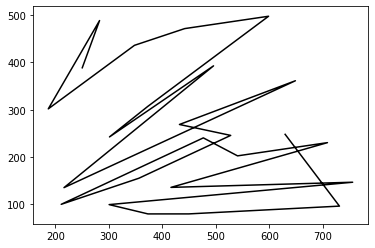

record the last path to gazebo for showing up
Avg Actor 5487.10498046875 --- Avg Critic 4649.44580078125
Epoch: 9, epoch time: 12.928min, tot time: 0.092day, L_actor: 5487.105, L_critic: 4649.446, update: False
Save Checkpoints
epoch:10, batch:100/500, reward:5046.9560546875


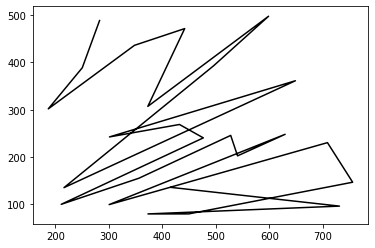

record the last path to gazebo for showing up
epoch:10, batch:200/500, reward:5050.60400390625


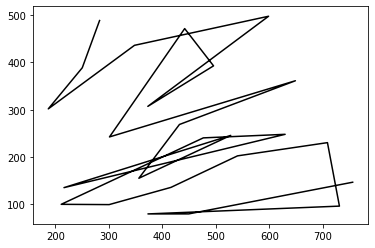

record the last path to gazebo for showing up
epoch:10, batch:300/500, reward:5001.3017578125


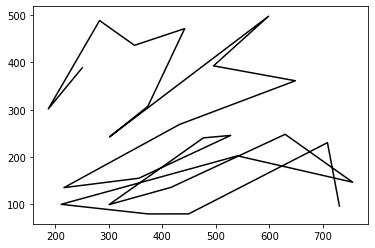

record the last path to gazebo for showing up
epoch:10, batch:400/500, reward:5049.90966796875


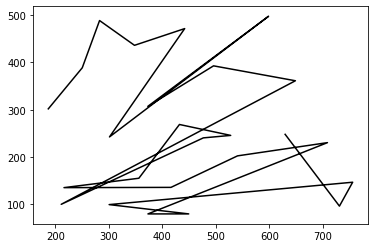

record the last path to gazebo for showing up
epoch:10, batch:500/500, reward:5058.2158203125


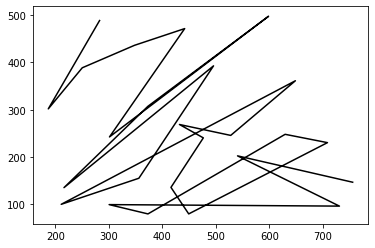

record the last path to gazebo for showing up
Avg Actor 5487.10498046875 --- Avg Critic 4649.44580078125
Epoch: 10, epoch time: 12.928min, tot time: 0.101day, L_actor: 5487.105, L_critic: 4649.446, update: False
Save Checkpoints
epoch:11, batch:100/500, reward:5033.67919921875


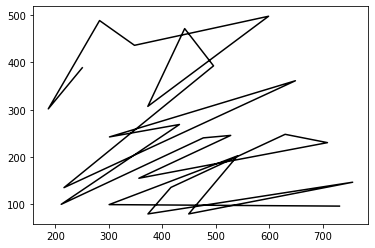

record the last path to gazebo for showing up
epoch:11, batch:200/500, reward:5027.8603515625


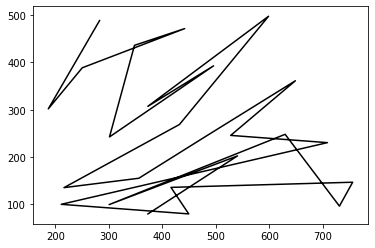

record the last path to gazebo for showing up
epoch:11, batch:300/500, reward:5038.9072265625


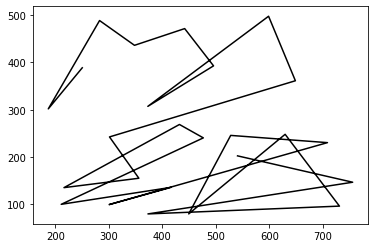

record the last path to gazebo for showing up
epoch:11, batch:400/500, reward:5043.4111328125


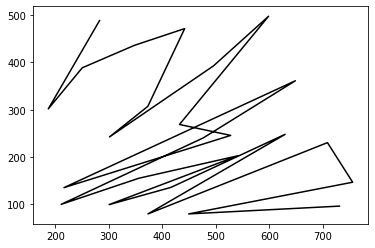

record the last path to gazebo for showing up
epoch:11, batch:500/500, reward:5039.8427734375


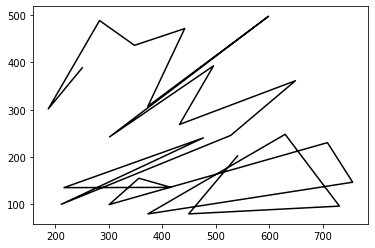

record the last path to gazebo for showing up
Avg Actor 5487.10498046875 --- Avg Critic 4649.44580078125
Epoch: 11, epoch time: 12.924min, tot time: 0.110day, L_actor: 5487.105, L_critic: 4649.446, update: False
Save Checkpoints
epoch:12, batch:100/500, reward:5078.84814453125


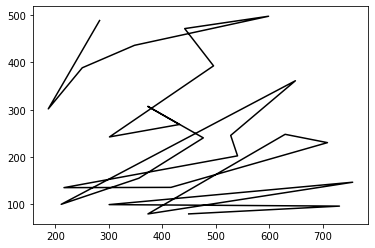

record the last path to gazebo for showing up
epoch:12, batch:200/500, reward:5032.6669921875


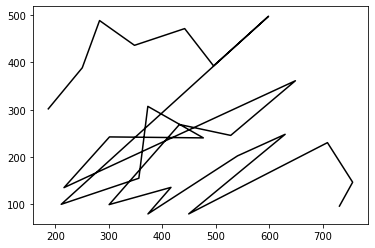

record the last path to gazebo for showing up
epoch:12, batch:300/500, reward:5045.68359375


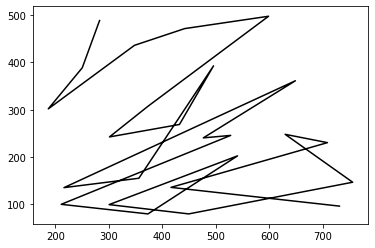

record the last path to gazebo for showing up
epoch:12, batch:400/500, reward:5053.5654296875


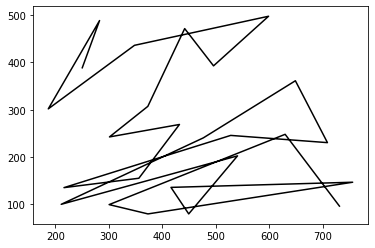

record the last path to gazebo for showing up
epoch:12, batch:500/500, reward:5051.0771484375


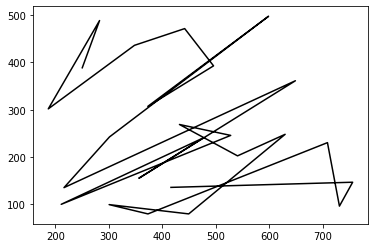

record the last path to gazebo for showing up
Avg Actor 5487.10498046875 --- Avg Critic 4649.44580078125
Epoch: 12, epoch time: 12.925min, tot time: 0.120day, L_actor: 5487.105, L_critic: 4649.446, update: False
Save Checkpoints
epoch:13, batch:100/500, reward:5006.02783203125


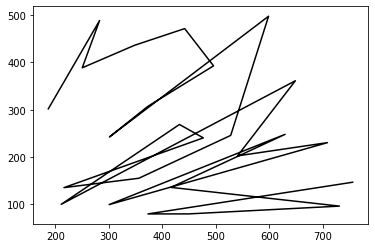

record the last path to gazebo for showing up
epoch:13, batch:200/500, reward:5046.3037109375


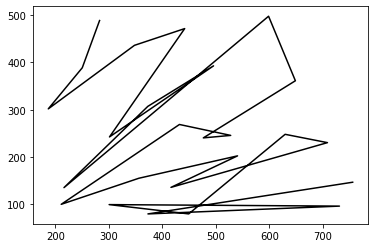

record the last path to gazebo for showing up
epoch:13, batch:300/500, reward:5006.86962890625


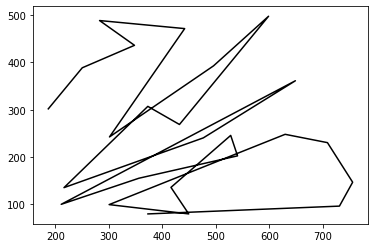

record the last path to gazebo for showing up
epoch:13, batch:400/500, reward:5190.7060546875


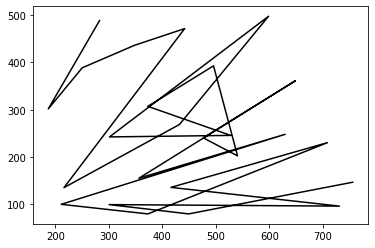

record the last path to gazebo for showing up
epoch:13, batch:500/500, reward:5138.09765625


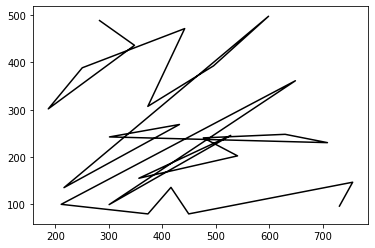

record the last path to gazebo for showing up
Avg Actor 5543.4765625 --- Avg Critic 4649.44580078125
Epoch: 13, epoch time: 12.926min, tot time: 0.129day, L_actor: 5543.477, L_critic: 4649.446, update: False
Save Checkpoints
epoch:14, batch:100/500, reward:5219.01708984375


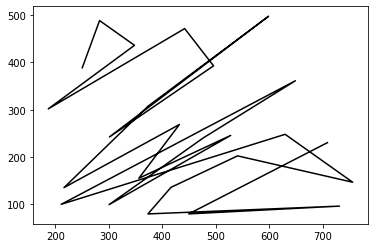

record the last path to gazebo for showing up
epoch:14, batch:200/500, reward:5136.53076171875


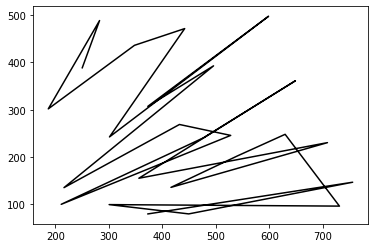

record the last path to gazebo for showing up
epoch:14, batch:300/500, reward:5055.24560546875


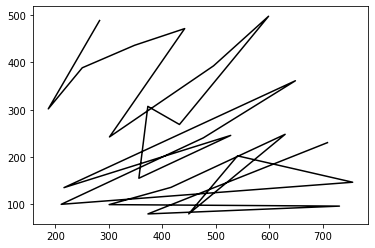

record the last path to gazebo for showing up
epoch:14, batch:400/500, reward:5058.26611328125


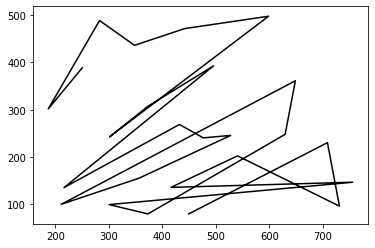

record the last path to gazebo for showing up
epoch:14, batch:500/500, reward:5089.75732421875


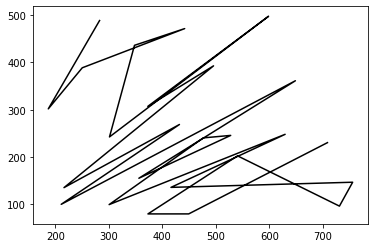

record the last path to gazebo for showing up
Avg Actor 5581.60595703125 --- Avg Critic 4649.44580078125
Epoch: 14, epoch time: 12.926min, tot time: 0.138day, L_actor: 5581.606, L_critic: 4649.446, update: False
Save Checkpoints
epoch:15, batch:100/500, reward:5121.6708984375


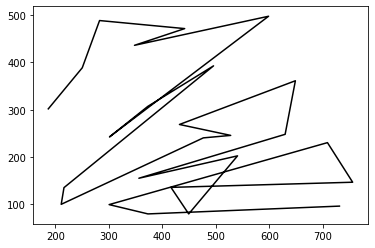

record the last path to gazebo for showing up
epoch:15, batch:200/500, reward:5292.31298828125


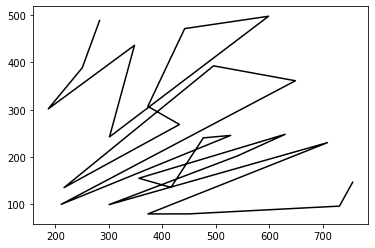

record the last path to gazebo for showing up
epoch:15, batch:300/500, reward:5195.5078125


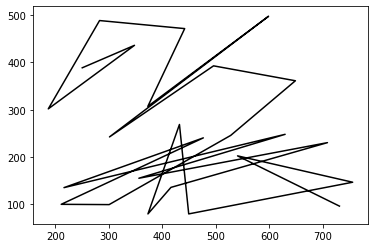

record the last path to gazebo for showing up
epoch:15, batch:400/500, reward:5247.5068359375


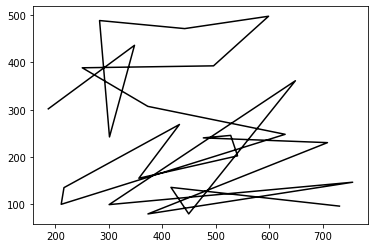

record the last path to gazebo for showing up
epoch:15, batch:500/500, reward:5237.736328125


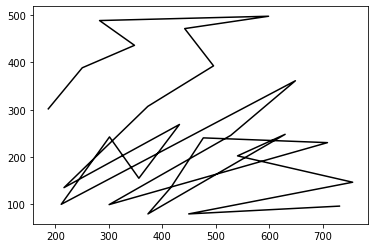

record the last path to gazebo for showing up
Avg Actor 5497.04296875 --- Avg Critic 4649.44580078125
Epoch: 15, epoch time: 12.926min, tot time: 0.147day, L_actor: 5497.043, L_critic: 4649.446, update: False
Save Checkpoints
epoch:16, batch:100/500, reward:5222.2021484375


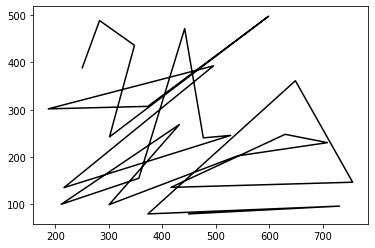

record the last path to gazebo for showing up
epoch:16, batch:200/500, reward:5214.16650390625


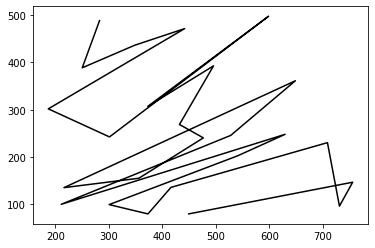

record the last path to gazebo for showing up
epoch:16, batch:300/500, reward:5283.34716796875


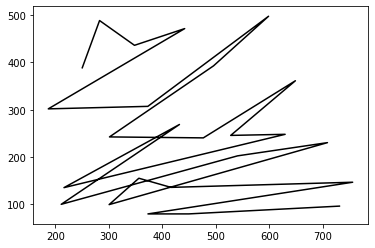

record the last path to gazebo for showing up
epoch:16, batch:400/500, reward:5271.79150390625


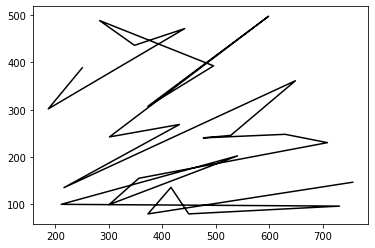

record the last path to gazebo for showing up
epoch:16, batch:500/500, reward:5284.23095703125


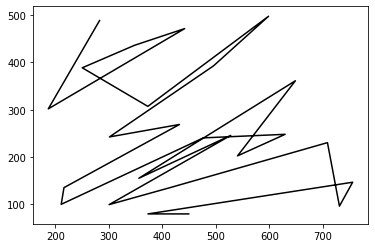

record the last path to gazebo for showing up
Avg Actor 5986.35205078125 --- Avg Critic 4649.44580078125
Epoch: 16, epoch time: 12.923min, tot time: 0.156day, L_actor: 5986.352, L_critic: 4649.446, update: False
Save Checkpoints
epoch:17, batch:100/500, reward:5189.06591796875


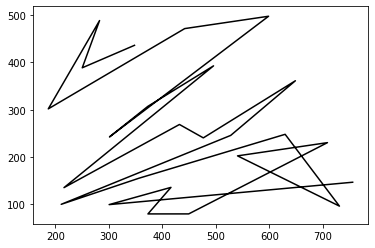

record the last path to gazebo for showing up
epoch:17, batch:200/500, reward:5250.2646484375


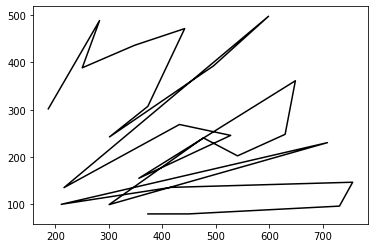

record the last path to gazebo for showing up
epoch:17, batch:300/500, reward:5252.4306640625


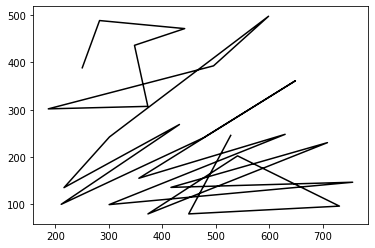

record the last path to gazebo for showing up
epoch:17, batch:400/500, reward:5214.73291015625


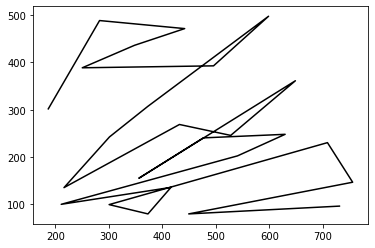

record the last path to gazebo for showing up
epoch:17, batch:500/500, reward:5224.8056640625


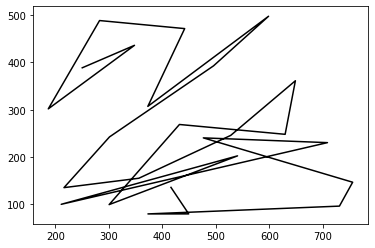

record the last path to gazebo for showing up
Avg Actor 5970.09033203125 --- Avg Critic 4649.44580078125
Epoch: 17, epoch time: 12.925min, tot time: 0.166day, L_actor: 5970.090, L_critic: 4649.446, update: False
Save Checkpoints
epoch:18, batch:100/500, reward:5190.1953125


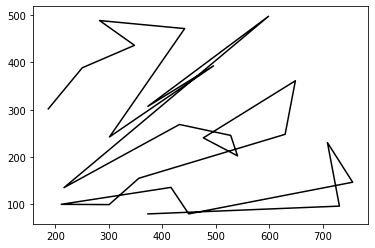

record the last path to gazebo for showing up
epoch:18, batch:200/500, reward:5228.81591796875


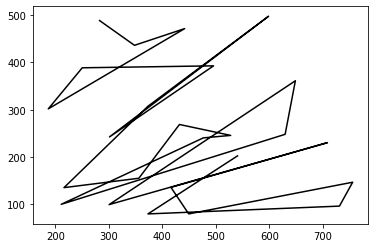

record the last path to gazebo for showing up
epoch:18, batch:300/500, reward:5204.02099609375


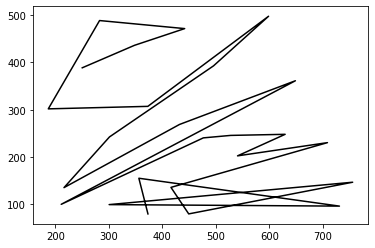

record the last path to gazebo for showing up
epoch:18, batch:400/500, reward:5169.55517578125


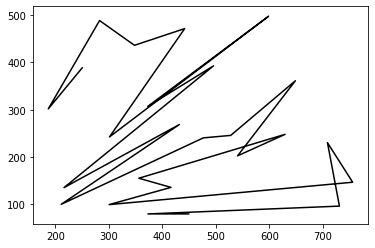

record the last path to gazebo for showing up
epoch:18, batch:500/500, reward:5185.17724609375


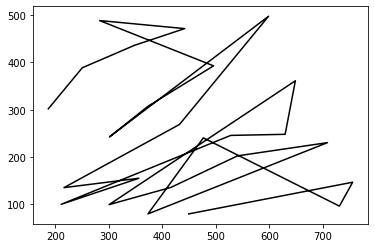

record the last path to gazebo for showing up
Avg Actor 5663.55419921875 --- Avg Critic 4649.44580078125
Epoch: 18, epoch time: 12.925min, tot time: 0.175day, L_actor: 5663.554, L_critic: 4649.446, update: False
Save Checkpoints
epoch:19, batch:100/500, reward:5230.7353515625


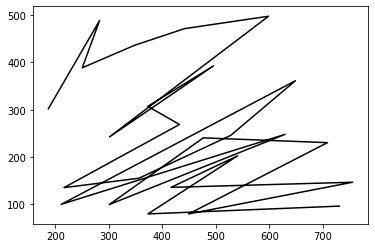

record the last path to gazebo for showing up
epoch:19, batch:200/500, reward:5169.47705078125


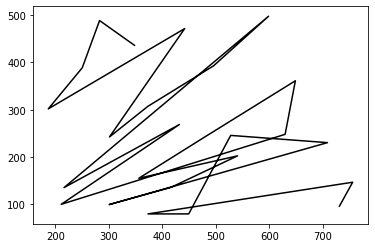

record the last path to gazebo for showing up
epoch:19, batch:300/500, reward:5191.7109375


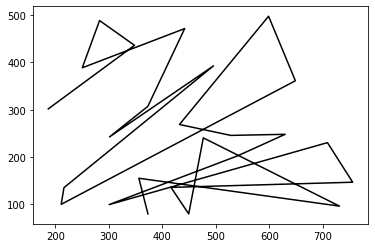

record the last path to gazebo for showing up
epoch:19, batch:400/500, reward:5150.4560546875


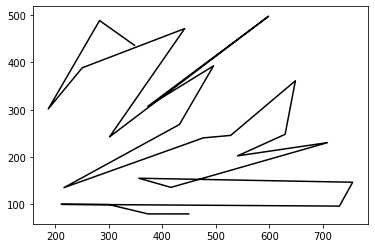

record the last path to gazebo for showing up
epoch:19, batch:500/500, reward:5147.0595703125


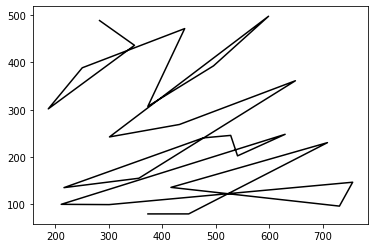

record the last path to gazebo for showing up
Avg Actor 5961.45263671875 --- Avg Critic 4649.44580078125
Epoch: 19, epoch time: 12.919min, tot time: 0.184day, L_actor: 5961.453, L_critic: 4649.446, update: False
Save Checkpoints
epoch:20, batch:100/500, reward:5180.84033203125


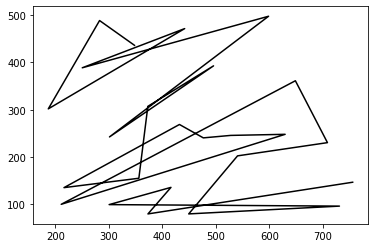

record the last path to gazebo for showing up
epoch:20, batch:200/500, reward:5150.0830078125


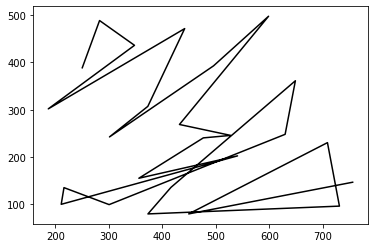

record the last path to gazebo for showing up
epoch:20, batch:300/500, reward:5140.19384765625


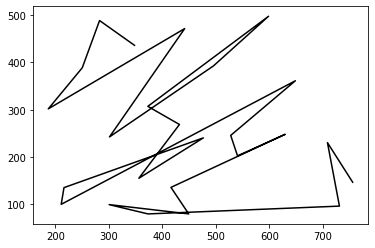

record the last path to gazebo for showing up
epoch:20, batch:400/500, reward:5147.1201171875


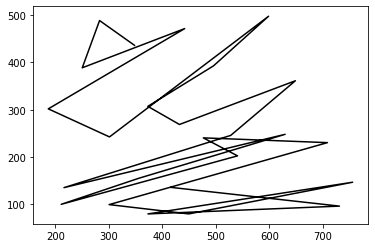

record the last path to gazebo for showing up
epoch:20, batch:500/500, reward:5184.4482421875


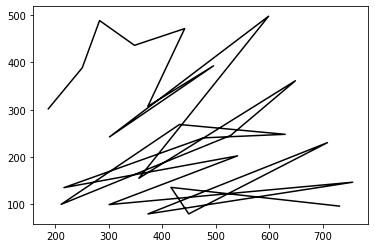

record the last path to gazebo for showing up
Avg Actor 5961.45263671875 --- Avg Critic 4649.44580078125
Epoch: 20, epoch time: 12.919min, tot time: 0.193day, L_actor: 5961.453, L_critic: 4649.446, update: False
Save Checkpoints
epoch:21, batch:100/500, reward:5067.736328125


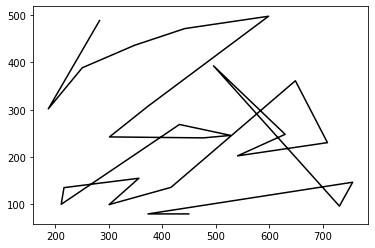

record the last path to gazebo for showing up
epoch:21, batch:200/500, reward:5094.8447265625


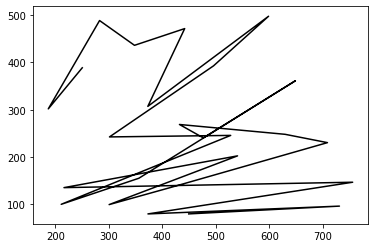

record the last path to gazebo for showing up
epoch:21, batch:300/500, reward:5164.623046875


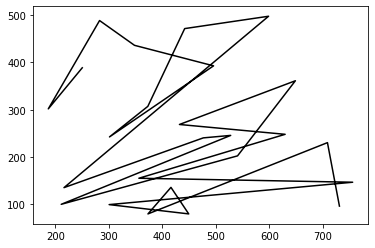

record the last path to gazebo for showing up
epoch:21, batch:400/500, reward:5141.943359375


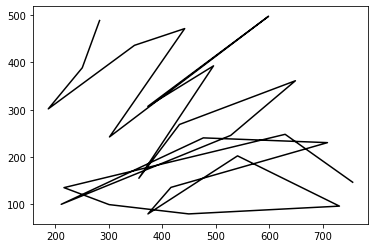

record the last path to gazebo for showing up
epoch:21, batch:500/500, reward:5186.8583984375


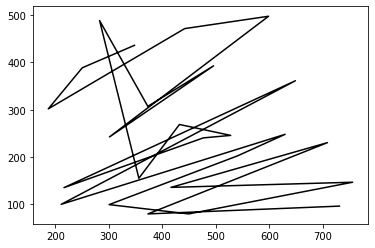

record the last path to gazebo for showing up
Avg Actor 5961.45263671875 --- Avg Critic 4649.44580078125
Epoch: 21, epoch time: 12.918min, tot time: 0.202day, L_actor: 5961.453, L_critic: 4649.446, update: False
Save Checkpoints
epoch:22, batch:100/500, reward:5113.3720703125


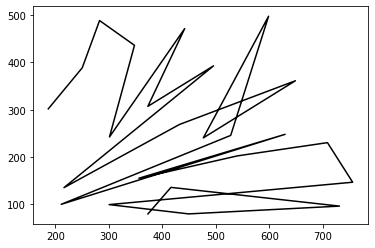

record the last path to gazebo for showing up
epoch:22, batch:200/500, reward:5144.86962890625


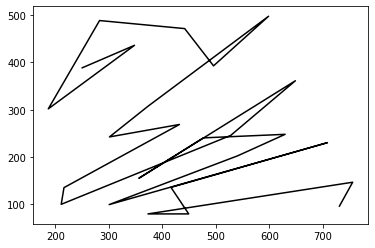

record the last path to gazebo for showing up
epoch:22, batch:300/500, reward:5143.9306640625


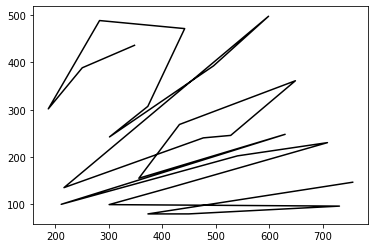

record the last path to gazebo for showing up
epoch:22, batch:400/500, reward:5140.6669921875


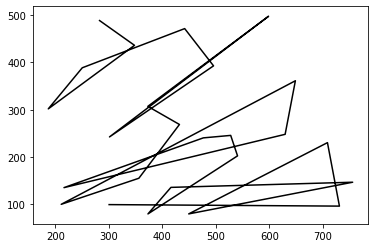

record the last path to gazebo for showing up
epoch:22, batch:500/500, reward:5131.076171875


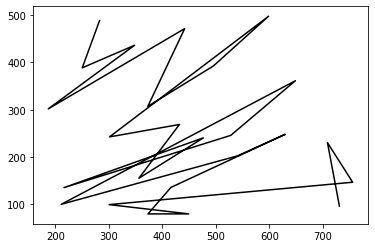

record the last path to gazebo for showing up
Avg Actor 5961.45263671875 --- Avg Critic 4649.44580078125
Epoch: 22, epoch time: 12.918min, tot time: 0.212day, L_actor: 5961.453, L_critic: 4649.446, update: False
Save Checkpoints
epoch:23, batch:100/500, reward:5161.47998046875


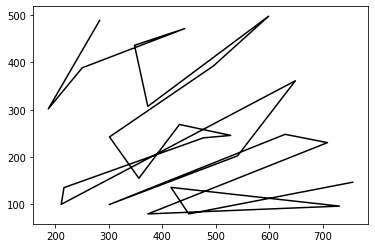

record the last path to gazebo for showing up
epoch:23, batch:200/500, reward:5098.9306640625


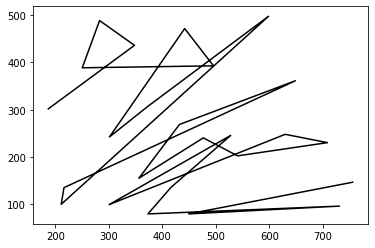

record the last path to gazebo for showing up
epoch:23, batch:300/500, reward:5172.521484375


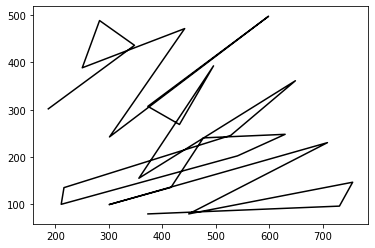

record the last path to gazebo for showing up
epoch:23, batch:400/500, reward:5111.3388671875


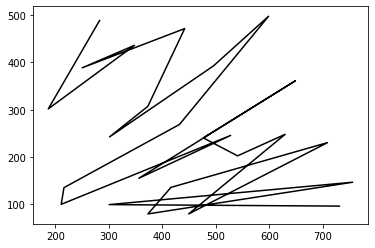

record the last path to gazebo for showing up
epoch:23, batch:500/500, reward:5134.96923828125


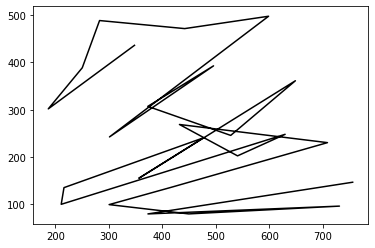

record the last path to gazebo for showing up
Avg Actor 5970.09033203125 --- Avg Critic 4649.44580078125
Epoch: 23, epoch time: 12.924min, tot time: 0.221day, L_actor: 5970.090, L_critic: 4649.446, update: False
Save Checkpoints
epoch:24, batch:100/500, reward:5096.80615234375


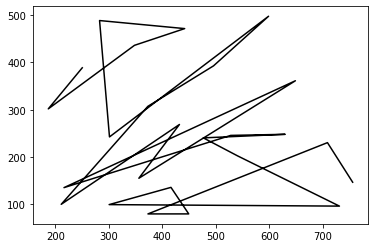

record the last path to gazebo for showing up
epoch:24, batch:200/500, reward:5130.33056640625


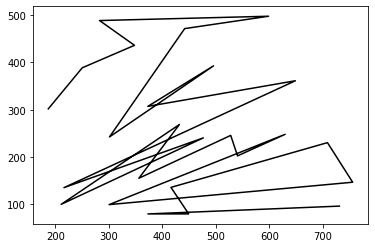

record the last path to gazebo for showing up
epoch:24, batch:300/500, reward:5117.13671875


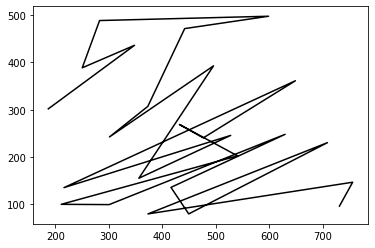

record the last path to gazebo for showing up
epoch:24, batch:400/500, reward:5134.2138671875


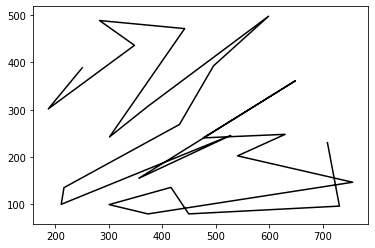

record the last path to gazebo for showing up
epoch:24, batch:500/500, reward:5110.50244140625


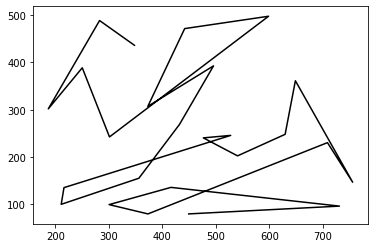

record the last path to gazebo for showing up
Avg Actor 5961.45263671875 --- Avg Critic 4649.44580078125
Epoch: 24, epoch time: 12.925min, tot time: 0.230day, L_actor: 5961.453, L_critic: 4649.446, update: False
Save Checkpoints
epoch:25, batch:100/500, reward:5095.22216796875


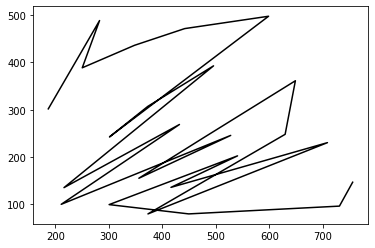

record the last path to gazebo for showing up
epoch:25, batch:200/500, reward:5150.85791015625


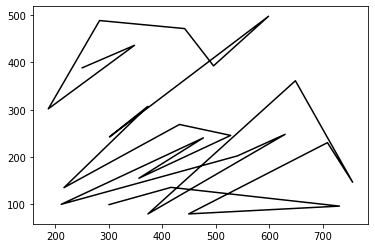

record the last path to gazebo for showing up
epoch:25, batch:300/500, reward:5120.75146484375


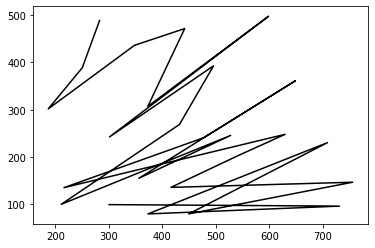

record the last path to gazebo for showing up
epoch:25, batch:400/500, reward:5097.08203125


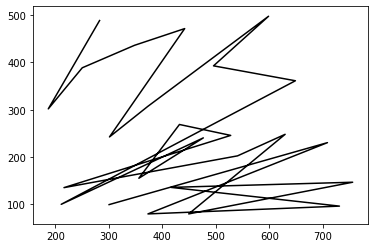

record the last path to gazebo for showing up
epoch:25, batch:500/500, reward:5131.14501953125


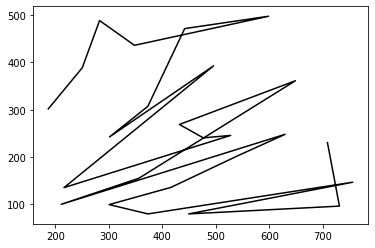

record the last path to gazebo for showing up
Avg Actor 5986.35205078125 --- Avg Critic 4649.44580078125
Epoch: 25, epoch time: 12.925min, tot time: 0.239day, L_actor: 5986.352, L_critic: 4649.446, update: False
Save Checkpoints
epoch:26, batch:100/500, reward:5071.587890625


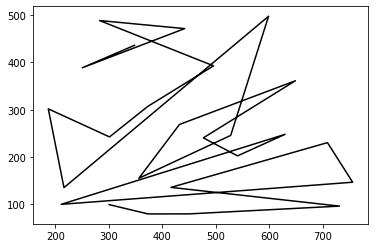

record the last path to gazebo for showing up
epoch:26, batch:200/500, reward:5154.98291015625


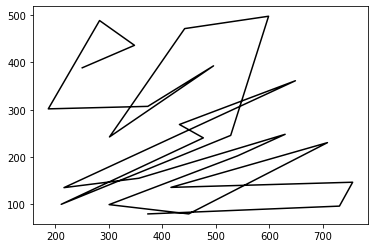

record the last path to gazebo for showing up
epoch:26, batch:300/500, reward:5134.43896484375


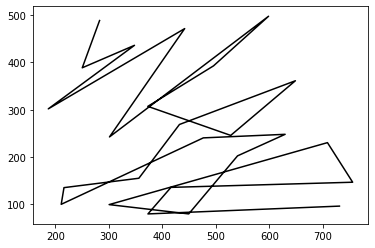

record the last path to gazebo for showing up
epoch:26, batch:400/500, reward:5129.5380859375


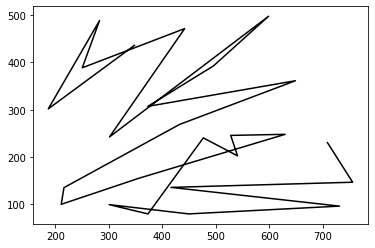

record the last path to gazebo for showing up
epoch:26, batch:500/500, reward:5112.296875


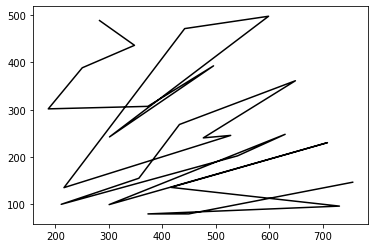

record the last path to gazebo for showing up
Avg Actor 5970.09033203125 --- Avg Critic 4649.44580078125
Epoch: 26, epoch time: 12.917min, tot time: 0.248day, L_actor: 5970.090, L_critic: 4649.446, update: False
Save Checkpoints
epoch:27, batch:100/500, reward:5083.7783203125


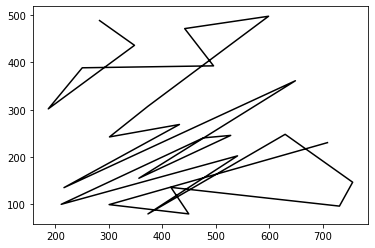

record the last path to gazebo for showing up
epoch:27, batch:200/500, reward:5147.23486328125


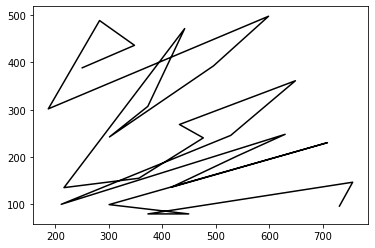

record the last path to gazebo for showing up
epoch:27, batch:300/500, reward:5101.51513671875


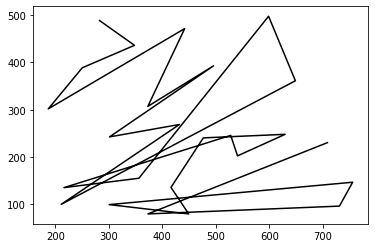

record the last path to gazebo for showing up
epoch:27, batch:400/500, reward:5067.375


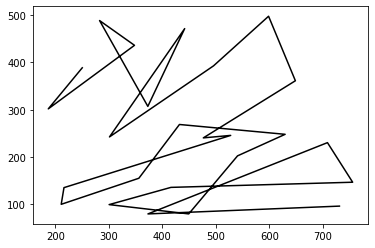

record the last path to gazebo for showing up
epoch:27, batch:500/500, reward:5089.87890625


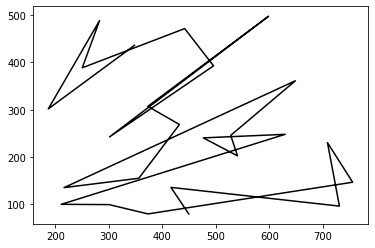

record the last path to gazebo for showing up
Avg Actor 5970.09033203125 --- Avg Critic 4649.44580078125
Epoch: 27, epoch time: 12.919min, tot time: 0.258day, L_actor: 5970.090, L_critic: 4649.446, update: False
Save Checkpoints
epoch:28, batch:100/500, reward:5079.12744140625


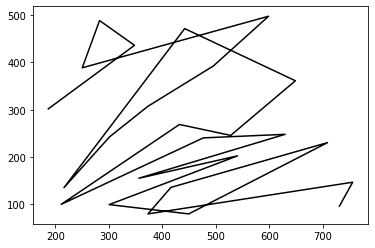

record the last path to gazebo for showing up
epoch:28, batch:200/500, reward:5109.0537109375


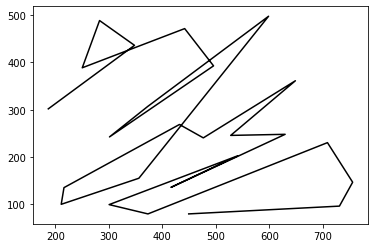

record the last path to gazebo for showing up
epoch:28, batch:300/500, reward:5039.9384765625


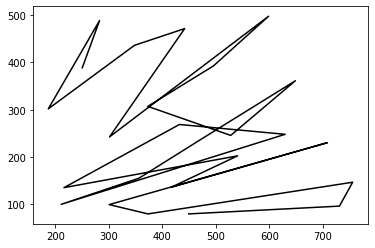

record the last path to gazebo for showing up
epoch:28, batch:400/500, reward:5055.2744140625


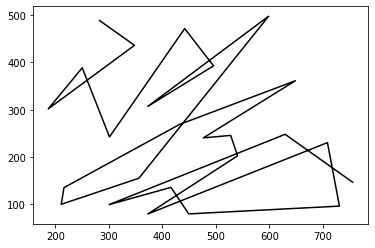

record the last path to gazebo for showing up
epoch:28, batch:500/500, reward:5071.921875


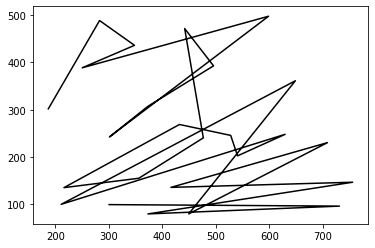

record the last path to gazebo for showing up
Avg Actor 5970.09033203125 --- Avg Critic 4649.44580078125
Epoch: 28, epoch time: 12.919min, tot time: 0.267day, L_actor: 5970.090, L_critic: 4649.446, update: False
Save Checkpoints
epoch:29, batch:100/500, reward:5075.291015625


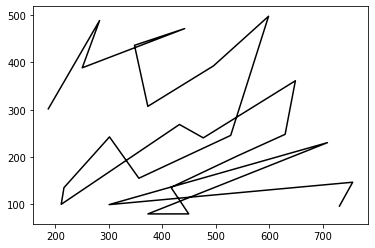

record the last path to gazebo for showing up
epoch:29, batch:200/500, reward:5108.01513671875


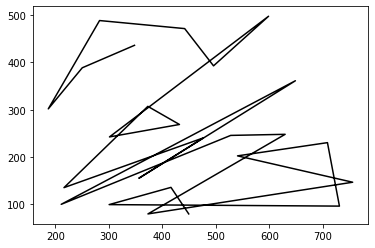

record the last path to gazebo for showing up
epoch:29, batch:300/500, reward:5096.7392578125


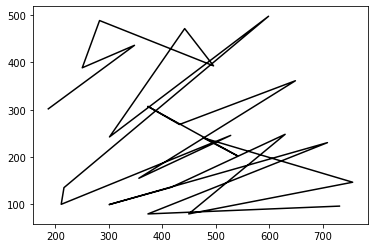

record the last path to gazebo for showing up
epoch:29, batch:400/500, reward:5023.671875


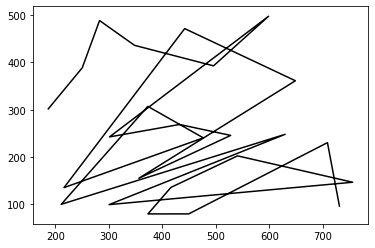

record the last path to gazebo for showing up
epoch:29, batch:500/500, reward:5076.9375


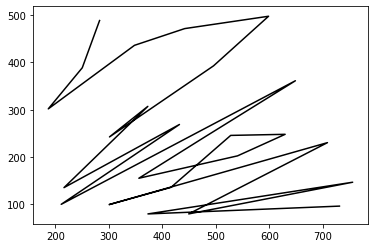

record the last path to gazebo for showing up
Avg Actor 5970.09033203125 --- Avg Critic 4649.44580078125
Epoch: 29, epoch time: 12.917min, tot time: 0.276day, L_actor: 5970.090, L_critic: 4649.446, update: False
Save Checkpoints
epoch:30, batch:100/500, reward:5091.1484375


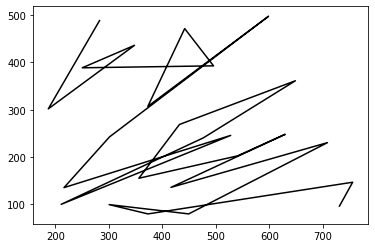

record the last path to gazebo for showing up
epoch:30, batch:200/500, reward:5076.1025390625


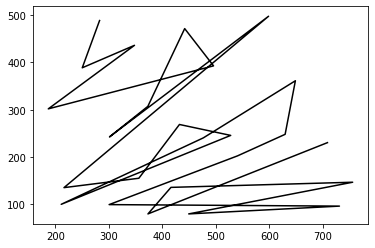

record the last path to gazebo for showing up
epoch:30, batch:300/500, reward:5037.126953125


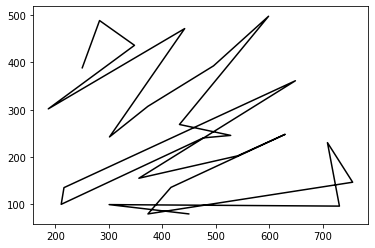

record the last path to gazebo for showing up
epoch:30, batch:400/500, reward:5107.8125


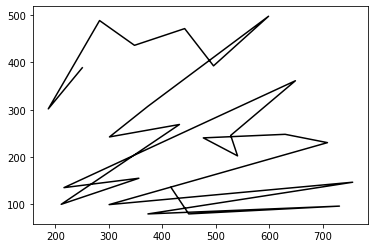

record the last path to gazebo for showing up
epoch:30, batch:500/500, reward:5084.419921875


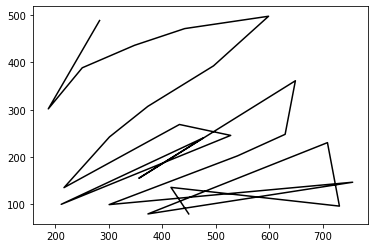

record the last path to gazebo for showing up
Avg Actor 6260.51611328125 --- Avg Critic 4649.44580078125
Epoch: 30, epoch time: 12.918min, tot time: 0.285day, L_actor: 6260.516, L_critic: 4649.446, update: False
Save Checkpoints
epoch:31, batch:100/500, reward:5075.85595703125


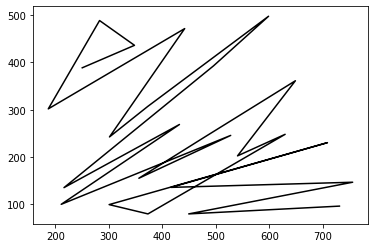

record the last path to gazebo for showing up
epoch:31, batch:200/500, reward:5122.19287109375


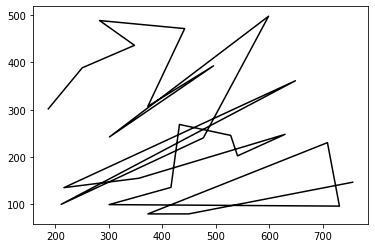

record the last path to gazebo for showing up
epoch:31, batch:300/500, reward:5142.87353515625


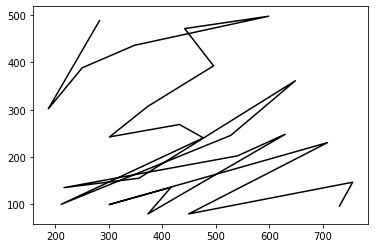

record the last path to gazebo for showing up
epoch:31, batch:400/500, reward:5054.91455078125


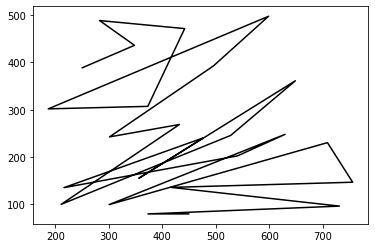

record the last path to gazebo for showing up
epoch:31, batch:500/500, reward:5115.08642578125


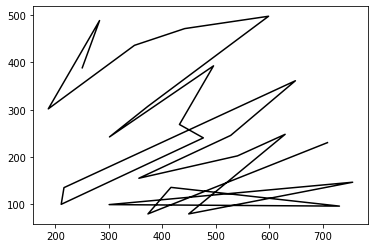

record the last path to gazebo for showing up
Avg Actor 6260.51611328125 --- Avg Critic 4649.44580078125
Epoch: 31, epoch time: 12.919min, tot time: 0.294day, L_actor: 6260.516, L_critic: 4649.446, update: False
Save Checkpoints
epoch:32, batch:100/500, reward:5090.98046875


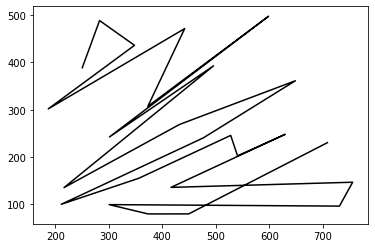

record the last path to gazebo for showing up
epoch:32, batch:200/500, reward:5062.75927734375


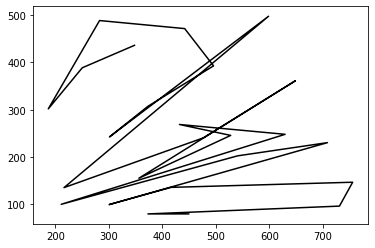

record the last path to gazebo for showing up
epoch:32, batch:300/500, reward:5063.4267578125


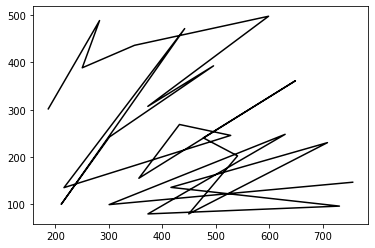

record the last path to gazebo for showing up
epoch:32, batch:400/500, reward:5121.51171875


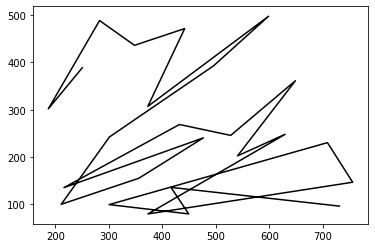

record the last path to gazebo for showing up
epoch:32, batch:500/500, reward:5098.875


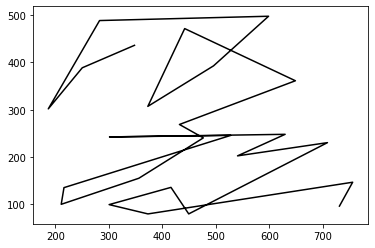

record the last path to gazebo for showing up
Avg Actor 6251.87939453125 --- Avg Critic 4649.44580078125
Epoch: 32, epoch time: 12.921min, tot time: 0.304day, L_actor: 6251.879, L_critic: 4649.446, update: False
Save Checkpoints
epoch:33, batch:100/500, reward:5071.435546875


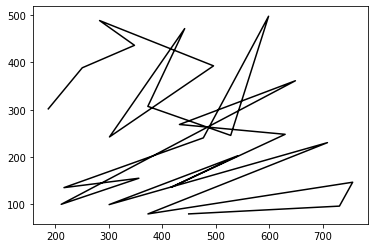

record the last path to gazebo for showing up
epoch:33, batch:200/500, reward:5102.61474609375


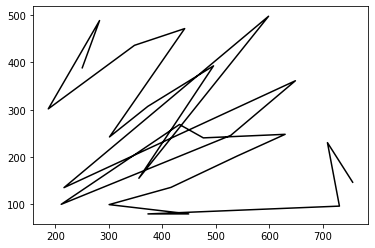

record the last path to gazebo for showing up
epoch:33, batch:300/500, reward:5114.33984375


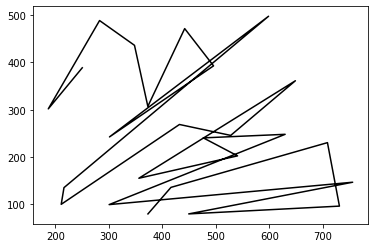

record the last path to gazebo for showing up
epoch:33, batch:400/500, reward:5054.759765625


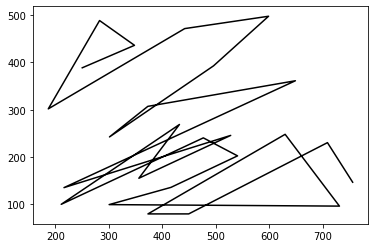

record the last path to gazebo for showing up
epoch:33, batch:500/500, reward:5077.181640625


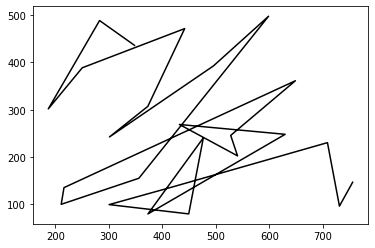

record the last path to gazebo for showing up
Avg Actor 6260.51611328125 --- Avg Critic 4649.44580078125
Epoch: 33, epoch time: 12.927min, tot time: 0.313day, L_actor: 6260.516, L_critic: 4649.446, update: False
Save Checkpoints
epoch:34, batch:100/500, reward:5034.3017578125


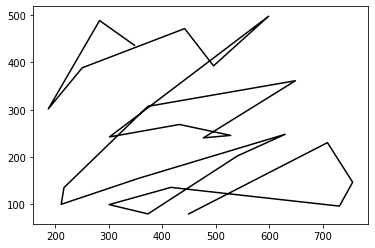

record the last path to gazebo for showing up
epoch:34, batch:200/500, reward:5105.13671875


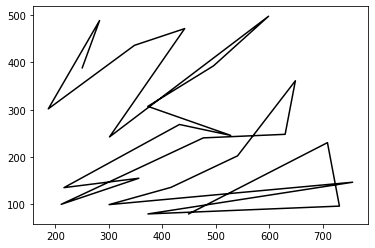

record the last path to gazebo for showing up
epoch:34, batch:300/500, reward:5082.64306640625


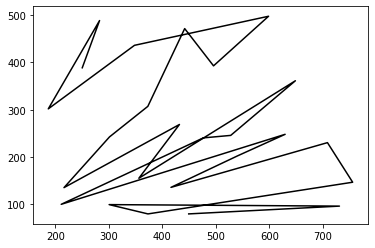

record the last path to gazebo for showing up
epoch:34, batch:400/500, reward:5093.11279296875


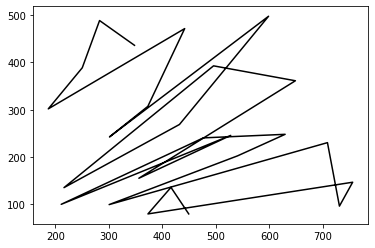

record the last path to gazebo for showing up
epoch:34, batch:500/500, reward:5113.1748046875


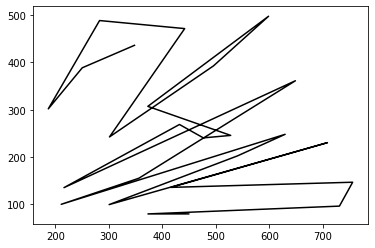

record the last path to gazebo for showing up
Avg Actor 6260.51611328125 --- Avg Critic 4649.44580078125
Epoch: 34, epoch time: 12.923min, tot time: 0.322day, L_actor: 6260.516, L_critic: 4649.446, update: False
Save Checkpoints
epoch:35, batch:100/500, reward:5079.42236328125


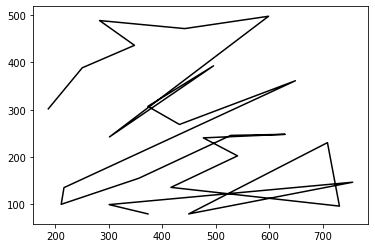

record the last path to gazebo for showing up
epoch:35, batch:200/500, reward:5093.369140625


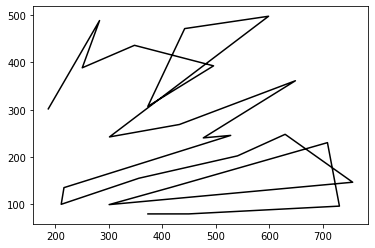

record the last path to gazebo for showing up
epoch:35, batch:300/500, reward:5098.8310546875


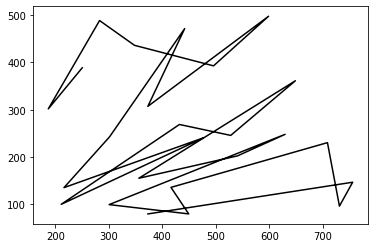

record the last path to gazebo for showing up
epoch:35, batch:400/500, reward:5059.3798828125


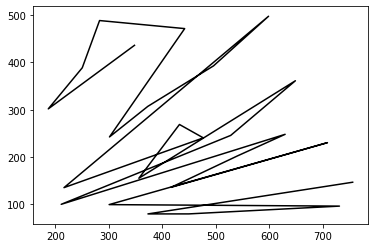

record the last path to gazebo for showing up
epoch:35, batch:500/500, reward:5114.74609375


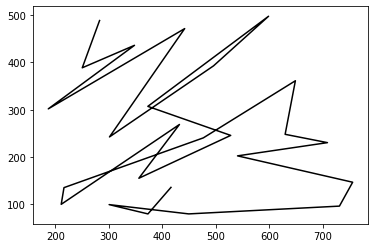

record the last path to gazebo for showing up
Avg Actor 6260.51611328125 --- Avg Critic 4649.44580078125
Epoch: 35, epoch time: 12.920min, tot time: 0.331day, L_actor: 6260.516, L_critic: 4649.446, update: False
Save Checkpoints
epoch:36, batch:100/500, reward:5064.1640625


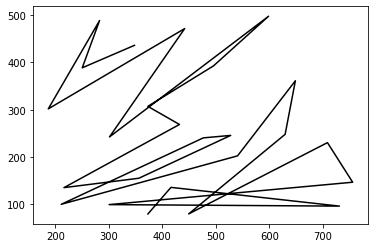

record the last path to gazebo for showing up
epoch:36, batch:200/500, reward:5054.3681640625


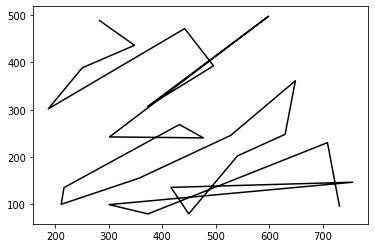

record the last path to gazebo for showing up
epoch:36, batch:300/500, reward:5095.74609375


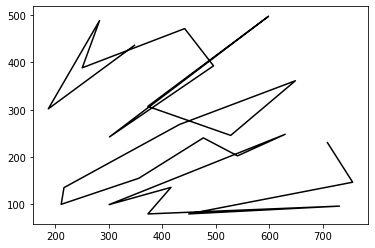

record the last path to gazebo for showing up
epoch:36, batch:400/500, reward:5074.8056640625


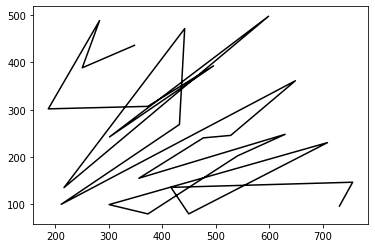

record the last path to gazebo for showing up
epoch:36, batch:500/500, reward:5035.57958984375


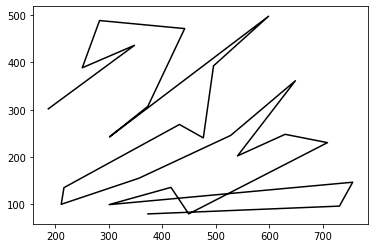

record the last path to gazebo for showing up
Avg Actor 6260.51611328125 --- Avg Critic 4649.44580078125
Epoch: 36, epoch time: 12.923min, tot time: 0.340day, L_actor: 6260.516, L_critic: 4649.446, update: False
Save Checkpoints
epoch:37, batch:100/500, reward:5089.7880859375


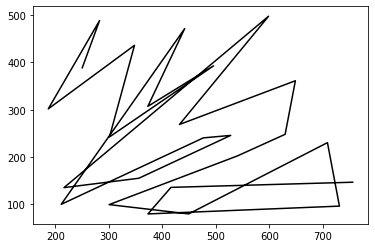

record the last path to gazebo for showing up
epoch:37, batch:200/500, reward:5109.626953125


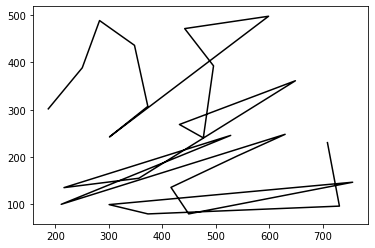

record the last path to gazebo for showing up
epoch:37, batch:300/500, reward:5071.56494140625


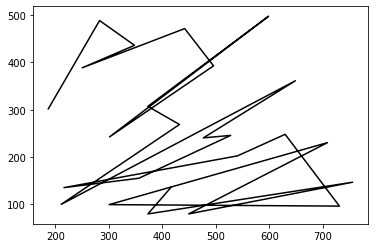

record the last path to gazebo for showing up
epoch:37, batch:400/500, reward:5129.1044921875


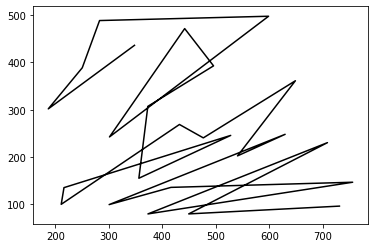

record the last path to gazebo for showing up
epoch:37, batch:500/500, reward:5079.14404296875


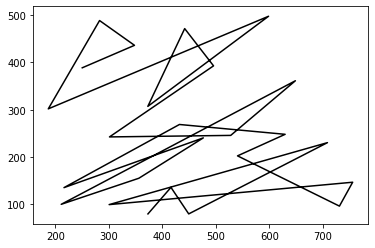

record the last path to gazebo for showing up
Avg Actor 6251.87939453125 --- Avg Critic 4649.44580078125
Epoch: 37, epoch time: 12.921min, tot time: 0.350day, L_actor: 6251.879, L_critic: 4649.446, update: False
Save Checkpoints
epoch:38, batch:100/500, reward:5001.654296875


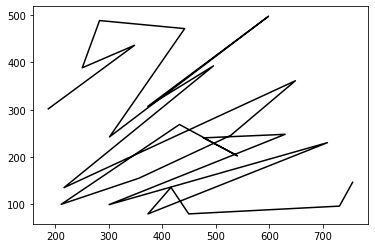

record the last path to gazebo for showing up
epoch:38, batch:200/500, reward:5110.34033203125


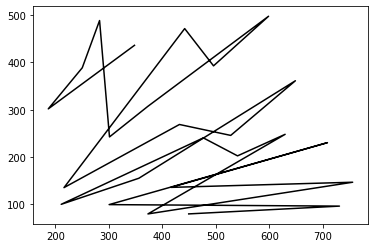

record the last path to gazebo for showing up
epoch:38, batch:300/500, reward:5106.25244140625


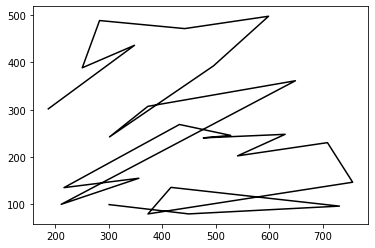

record the last path to gazebo for showing up
epoch:38, batch:400/500, reward:5026.80322265625


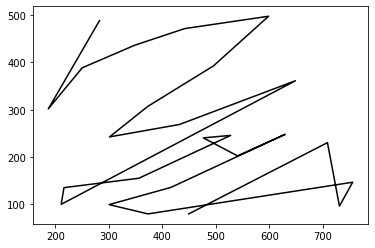

record the last path to gazebo for showing up
epoch:38, batch:500/500, reward:5039.236328125


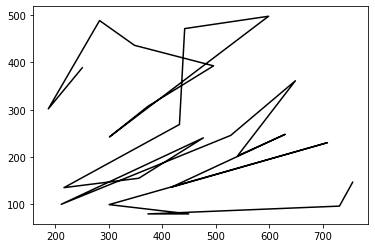

record the last path to gazebo for showing up
Avg Actor 6260.51611328125 --- Avg Critic 4649.44580078125
Epoch: 38, epoch time: 12.922min, tot time: 0.359day, L_actor: 6260.516, L_critic: 4649.446, update: False
Save Checkpoints
epoch:39, batch:100/500, reward:5086.48583984375


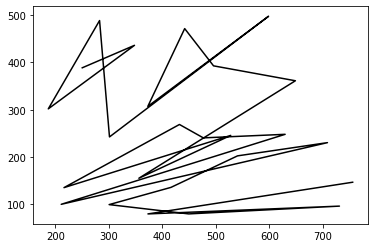

record the last path to gazebo for showing up
epoch:39, batch:200/500, reward:5078.6318359375


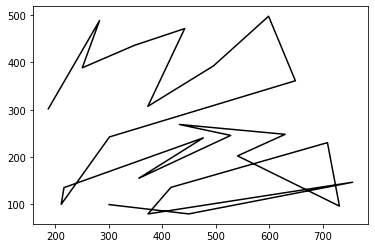

record the last path to gazebo for showing up
epoch:39, batch:300/500, reward:5077.482421875


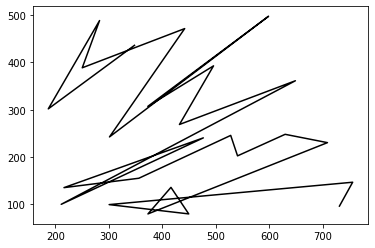

record the last path to gazebo for showing up
epoch:39, batch:400/500, reward:5091.3486328125


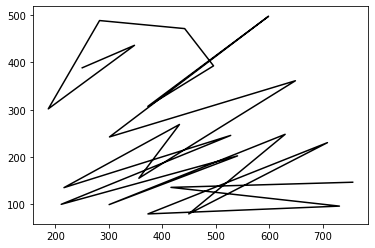

record the last path to gazebo for showing up
epoch:39, batch:500/500, reward:5083.56396484375


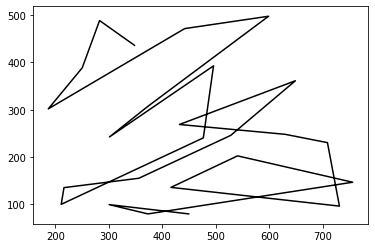

record the last path to gazebo for showing up
Avg Actor 6260.51611328125 --- Avg Critic 4649.44580078125
Epoch: 39, epoch time: 12.926min, tot time: 0.368day, L_actor: 6260.516, L_critic: 4649.446, update: False
Save Checkpoints
epoch:40, batch:100/500, reward:5047.09521484375


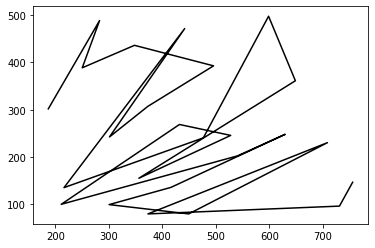

record the last path to gazebo for showing up
epoch:40, batch:200/500, reward:5048.47802734375


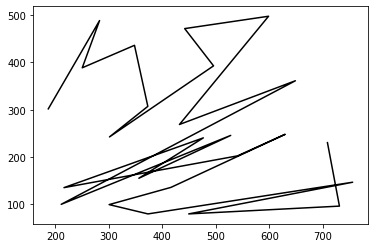

record the last path to gazebo for showing up
epoch:40, batch:300/500, reward:5083.29345703125


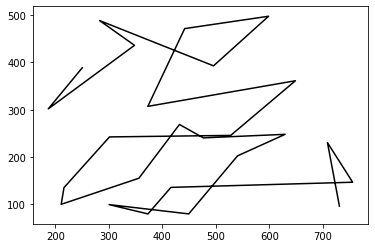

record the last path to gazebo for showing up
epoch:40, batch:400/500, reward:5113.2802734375


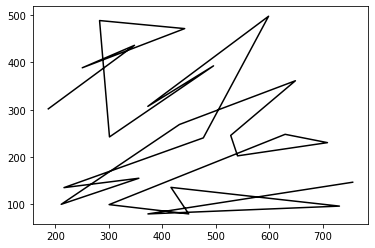

record the last path to gazebo for showing up
epoch:40, batch:500/500, reward:5040.38525390625


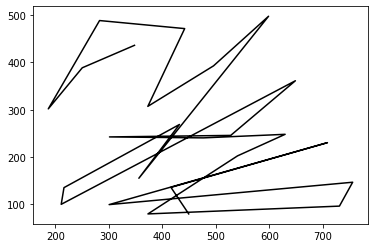

record the last path to gazebo for showing up
Avg Actor 6260.51611328125 --- Avg Critic 4649.44580078125
Epoch: 40, epoch time: 12.921min, tot time: 0.377day, L_actor: 6260.516, L_critic: 4649.446, update: False
Save Checkpoints
epoch:41, batch:100/500, reward:5073.4111328125


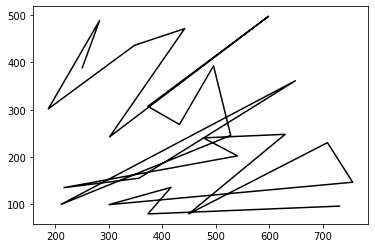

record the last path to gazebo for showing up
epoch:41, batch:200/500, reward:5106.6826171875


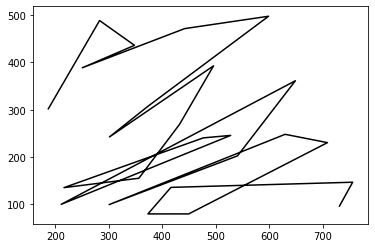

record the last path to gazebo for showing up
epoch:41, batch:300/500, reward:5070.0048828125


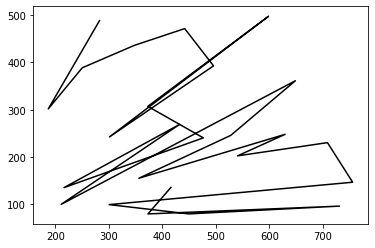

record the last path to gazebo for showing up
epoch:41, batch:400/500, reward:5103.57080078125


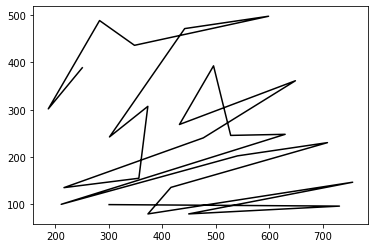

record the last path to gazebo for showing up
epoch:41, batch:500/500, reward:5067.2978515625


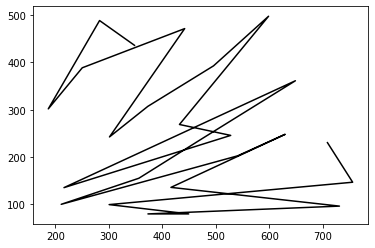

record the last path to gazebo for showing up
Avg Actor 6260.51611328125 --- Avg Critic 4649.44580078125
Epoch: 41, epoch time: 12.927min, tot time: 0.386day, L_actor: 6260.516, L_critic: 4649.446, update: False
Save Checkpoints
epoch:42, batch:100/500, reward:5110.40380859375


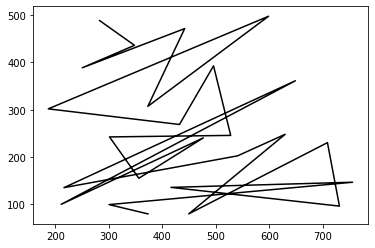

record the last path to gazebo for showing up
epoch:42, batch:200/500, reward:5011.927734375


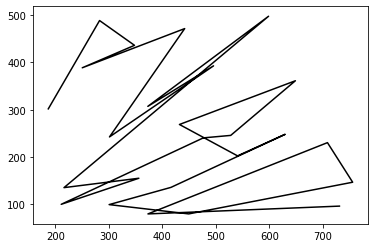

record the last path to gazebo for showing up
epoch:42, batch:300/500, reward:5075.22412109375


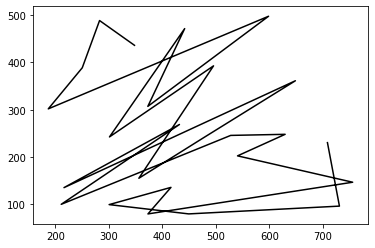

record the last path to gazebo for showing up
epoch:42, batch:400/500, reward:5067.064453125


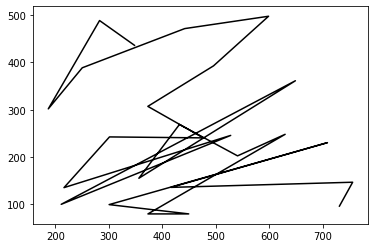

record the last path to gazebo for showing up
epoch:42, batch:500/500, reward:5120.2451171875


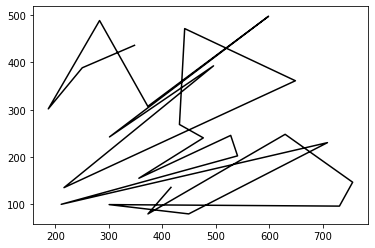

record the last path to gazebo for showing up
Avg Actor 6251.87939453125 --- Avg Critic 4649.44580078125
Epoch: 42, epoch time: 12.921min, tot time: 0.396day, L_actor: 6251.879, L_critic: 4649.446, update: False
Save Checkpoints
epoch:43, batch:100/500, reward:5108.7392578125


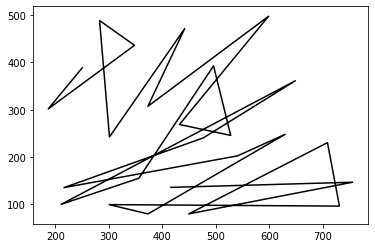

record the last path to gazebo for showing up
epoch:43, batch:200/500, reward:5122.5869140625


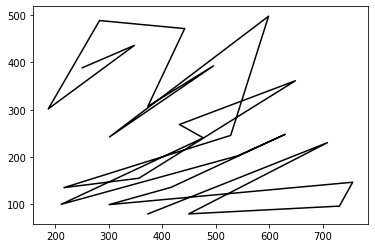

record the last path to gazebo for showing up
epoch:43, batch:300/500, reward:5093.7490234375


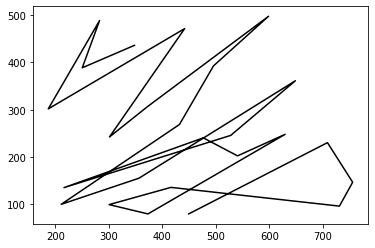

record the last path to gazebo for showing up
epoch:43, batch:400/500, reward:5070.650390625


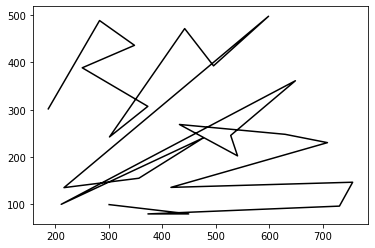

record the last path to gazebo for showing up
epoch:43, batch:500/500, reward:5069.2421875


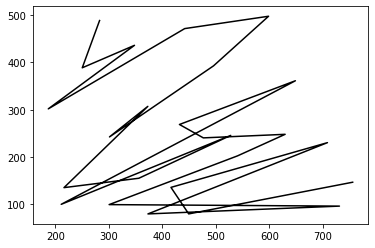

record the last path to gazebo for showing up
Avg Actor 5970.67529296875 --- Avg Critic 4649.44580078125
Epoch: 43, epoch time: 12.934min, tot time: 0.405day, L_actor: 5970.675, L_critic: 4649.446, update: False
Save Checkpoints
epoch:44, batch:100/500, reward:5078.3359375


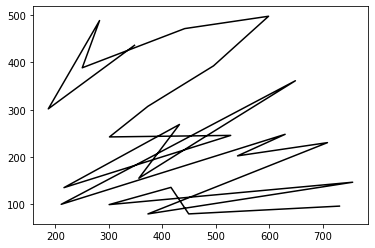

record the last path to gazebo for showing up
epoch:44, batch:200/500, reward:5007.93310546875


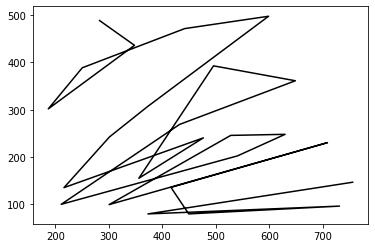

record the last path to gazebo for showing up
epoch:44, batch:300/500, reward:5110.9892578125


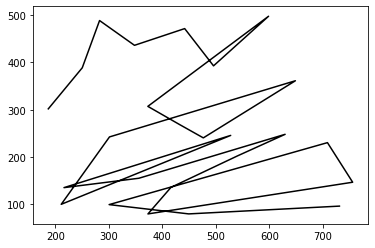

record the last path to gazebo for showing up
epoch:44, batch:400/500, reward:5112.28173828125


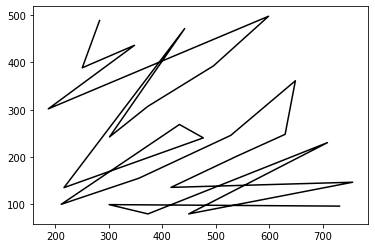

record the last path to gazebo for showing up
epoch:44, batch:500/500, reward:5026.9326171875


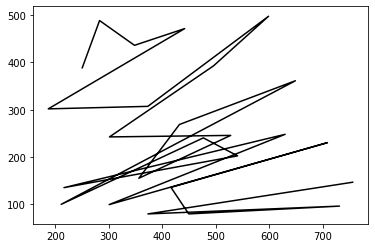

record the last path to gazebo for showing up
Avg Actor 5970.67529296875 --- Avg Critic 4649.44580078125
Epoch: 44, epoch time: 12.921min, tot time: 0.414day, L_actor: 5970.675, L_critic: 4649.446, update: False
Save Checkpoints
epoch:45, batch:100/500, reward:5089.05419921875


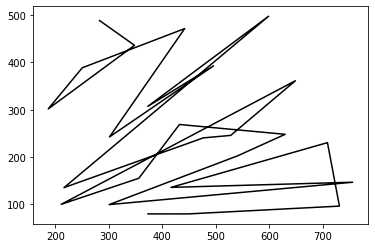

record the last path to gazebo for showing up
epoch:45, batch:200/500, reward:5101.255859375


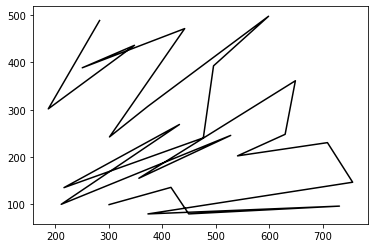

record the last path to gazebo for showing up
epoch:45, batch:300/500, reward:5084.09765625


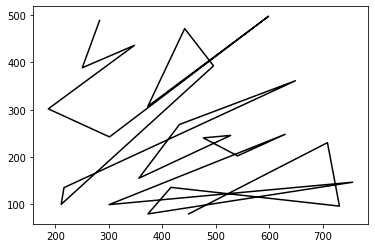

record the last path to gazebo for showing up
epoch:45, batch:400/500, reward:5058.9951171875


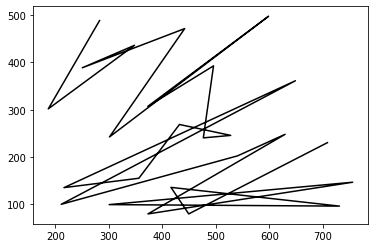

record the last path to gazebo for showing up
epoch:45, batch:500/500, reward:5081.56201171875


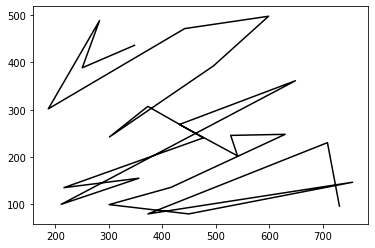

record the last path to gazebo for showing up
Avg Actor 5970.09033203125 --- Avg Critic 4649.44580078125
Epoch: 45, epoch time: 12.922min, tot time: 0.423day, L_actor: 5970.090, L_critic: 4649.446, update: False
Save Checkpoints
epoch:46, batch:100/500, reward:5057.1005859375


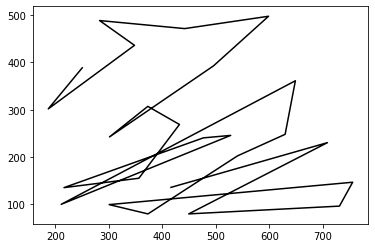

record the last path to gazebo for showing up
epoch:46, batch:200/500, reward:5086.87109375


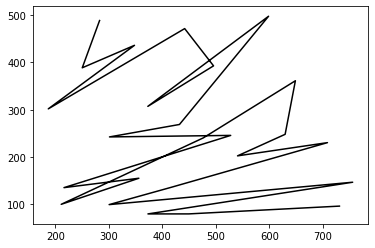

record the last path to gazebo for showing up
epoch:46, batch:300/500, reward:5088.42578125


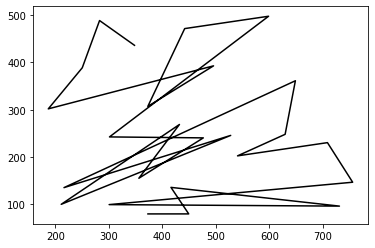

record the last path to gazebo for showing up
epoch:46, batch:400/500, reward:5149.609375


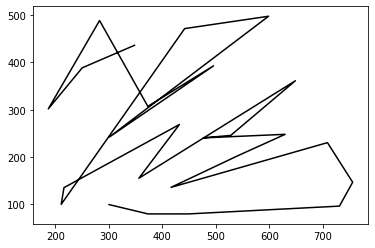

record the last path to gazebo for showing up
epoch:46, batch:500/500, reward:5045.1240234375


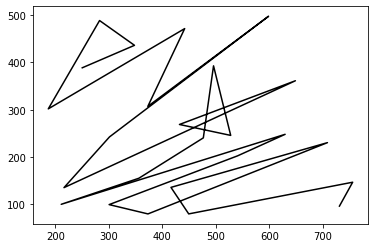

record the last path to gazebo for showing up
Avg Actor 6260.51611328125 --- Avg Critic 4649.44580078125
Epoch: 46, epoch time: 12.922min, tot time: 0.432day, L_actor: 6260.516, L_critic: 4649.446, update: False
Save Checkpoints
epoch:47, batch:100/500, reward:5088.189453125


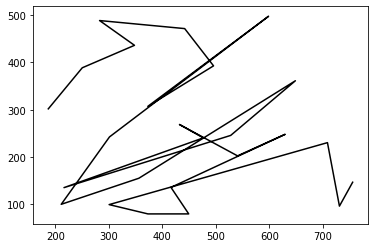

record the last path to gazebo for showing up
epoch:47, batch:200/500, reward:5059.828125


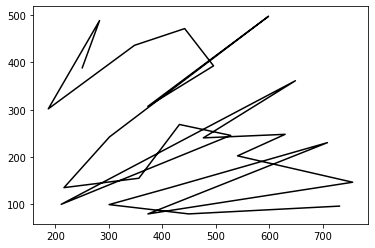

record the last path to gazebo for showing up
epoch:47, batch:300/500, reward:5067.40185546875


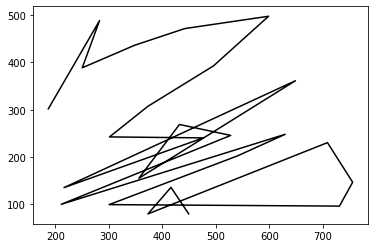

record the last path to gazebo for showing up
epoch:47, batch:400/500, reward:5128.2373046875


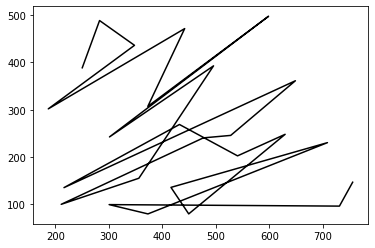

record the last path to gazebo for showing up
epoch:47, batch:500/500, reward:5060.24462890625


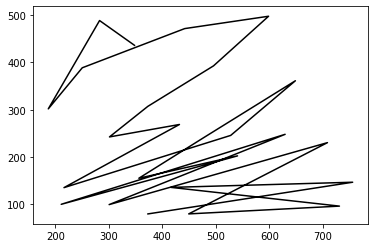

record the last path to gazebo for showing up
Avg Actor 6260.51611328125 --- Avg Critic 4649.44580078125
Epoch: 47, epoch time: 12.922min, tot time: 0.442day, L_actor: 6260.516, L_critic: 4649.446, update: False
Save Checkpoints
epoch:48, batch:100/500, reward:5090.943359375


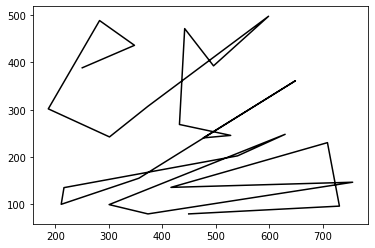

record the last path to gazebo for showing up
epoch:48, batch:200/500, reward:5071.94384765625


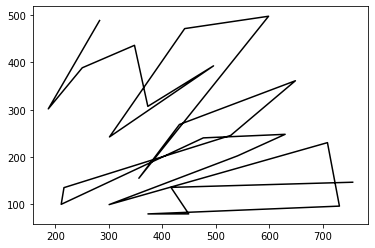

record the last path to gazebo for showing up
epoch:48, batch:300/500, reward:5066.173828125


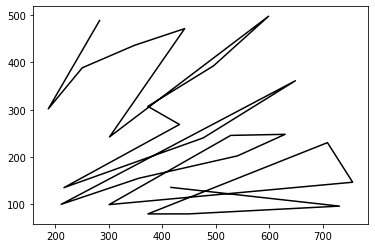

record the last path to gazebo for showing up
epoch:48, batch:400/500, reward:5069.67626953125


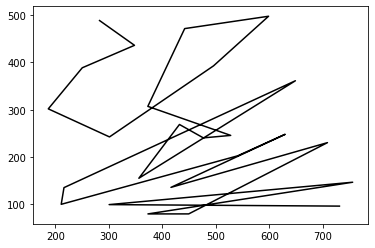

record the last path to gazebo for showing up
epoch:48, batch:500/500, reward:5110.533203125


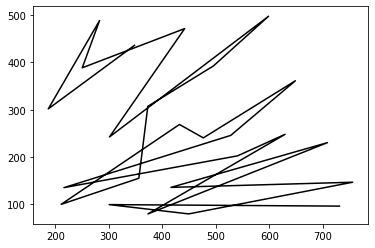

record the last path to gazebo for showing up
Avg Actor 6260.51611328125 --- Avg Critic 4649.44580078125
Epoch: 48, epoch time: 12.926min, tot time: 0.451day, L_actor: 6260.516, L_critic: 4649.446, update: False
Save Checkpoints
epoch:49, batch:100/500, reward:5074.166015625


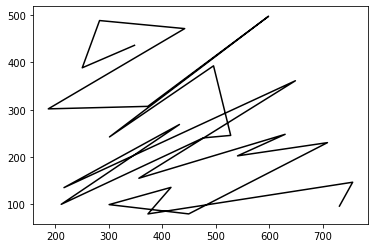

record the last path to gazebo for showing up
epoch:49, batch:200/500, reward:5090.0732421875


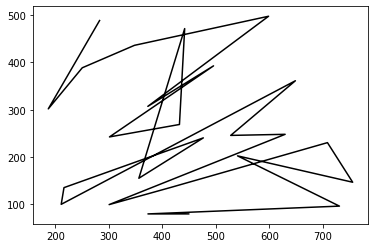

record the last path to gazebo for showing up
epoch:49, batch:300/500, reward:5106.7568359375


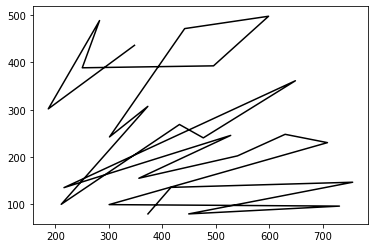

record the last path to gazebo for showing up
epoch:49, batch:400/500, reward:5096.14453125


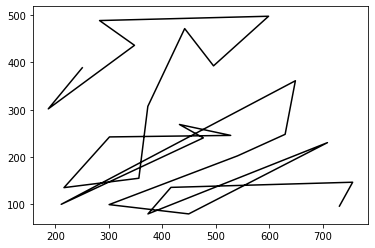

record the last path to gazebo for showing up
epoch:49, batch:500/500, reward:5084.07080078125


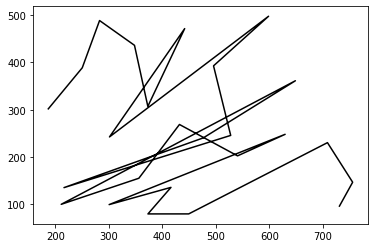

record the last path to gazebo for showing up
Avg Actor 6260.51611328125 --- Avg Critic 4649.44580078125
Epoch: 49, epoch time: 12.926min, tot time: 0.460day, L_actor: 6260.516, L_critic: 4649.446, update: False
Save Checkpoints
epoch:50, batch:100/500, reward:5096.880859375


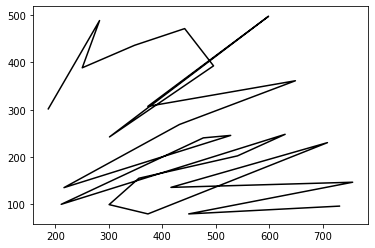

record the last path to gazebo for showing up
epoch:50, batch:200/500, reward:5031.6513671875


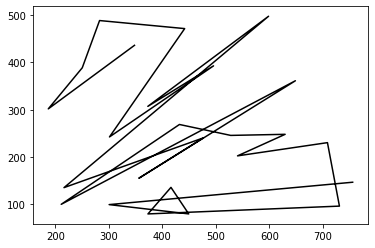

record the last path to gazebo for showing up
epoch:50, batch:300/500, reward:5100.9658203125


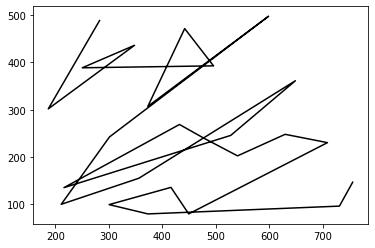

record the last path to gazebo for showing up
epoch:50, batch:400/500, reward:5114.244140625


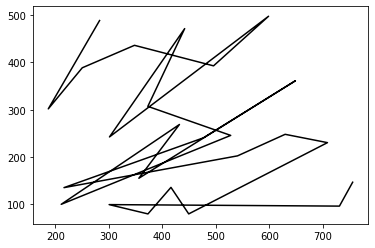

record the last path to gazebo for showing up
epoch:50, batch:500/500, reward:5070.7353515625


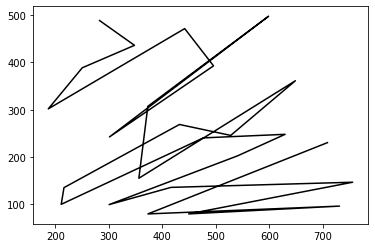

record the last path to gazebo for showing up
Avg Actor 6260.51611328125 --- Avg Critic 4649.44580078125
Epoch: 50, epoch time: 12.926min, tot time: 0.469day, L_actor: 6260.516, L_critic: 4649.446, update: False
Save Checkpoints
epoch:51, batch:100/500, reward:5440.2333984375


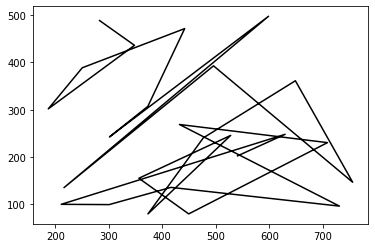

record the last path to gazebo for showing up
epoch:51, batch:200/500, reward:5260.05419921875


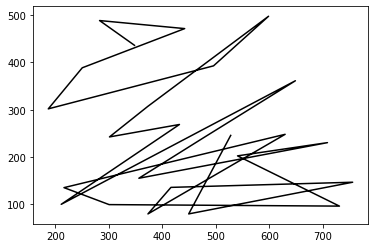

record the last path to gazebo for showing up
epoch:51, batch:300/500, reward:5227.9208984375


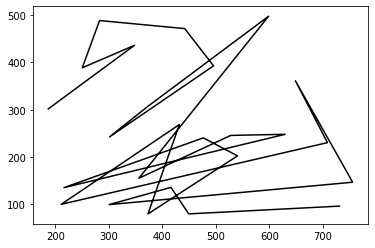

record the last path to gazebo for showing up
epoch:51, batch:400/500, reward:5383.6171875


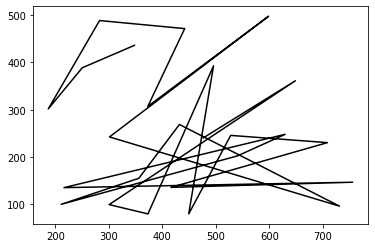

record the last path to gazebo for showing up


In [ ]:
import yaml
from torch.distributions.categorical import Categorical
# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm_notebook
####### my own import file ##########
from listofpathpoint import input_handler
import cnc_input
#from hybrid_models import HPN
####### my own import file ##########
'''
so, the models we have are TransEncoderNet,
                            Attention
                            LSTM
                            HPN
each one have initial parameters and the forward part, 
once we have the forward part, the back propagation will 
finished automatically by pytorch  
'''
TOL = 1e-3
TINY = 1e-15
learning_rate = 1e-4   #learning rate
B = 256             #batch size
B_valLoop = 20
steps = 500
n_epoch = 100       # epochs
map_number = 6
record_actor = []
record_critic = []
dimension = 3
speed_of_nozzle = 60

print('======================')
print('prepare to train')
print('======================')
print('Hyper parameters:')
print('learning rate', learning_rate)
print('batch size', B)
print('steps', steps)
print('epoch', n_epoch)
print('======================')

'''
instantiate a training network and a baseline network
'''


try:
    del Actor  # remove existing model
    del Critic # remove existing model
except:
    pass
Actor = HPN(n_feature = dimension, n_hidden = 128)
Critic = HPN(n_feature = dimension, n_hidden = 128)
optimizer = optim.Adam(Actor.parameters(), lr=learning_rate)

# Putting Critic model on the eval mode
Actor = Actor.to(device)
Critic = Critic.to(device)
Critic.eval()

epoch_ckpt = 0
tot_time_ckpt = 0

val_mean = []
val_std = []
maplist = ['10&15data/25_chips/25_1.json'
          ,'10&15data/25_chips/25_1.json','10&15data/25_chips/25_1.json'\
          ,'10&15data/25_chips/25_1.json','10&15data/25_chips/25_1.json','10&15data/25_chips/25_1.json'
          ]
          
plot_performance_train = []
plot_performance_baseline = []
# recording the result of the resent epoch makes it available for future
#*********************# Uncomment these lines to load the previous check point
"""
checkpoint_file = "checkpoint/mutimap_20.pkl"
checkpoint = torch.load(checkpoint_file, map_location=device)
epoch_ckpt = checkpoint['epoch'] + 1
tot_time_ckpt = checkpoint['tot_time']
plot_performance_train = checkpoint['plot_performance_train']
plot_performance_baseline = checkpoint['plot_performance_baseline']
Critic.load_state_dict(checkpoint['model_baseline'])
Actor.load_state_dict(checkpoint['model_train'])
optimizer.load_state_dict(checkpoint['optimizer'])

print('Re-start training with saved checkpoint file={:s}\n  Checkpoint at epoch= {:d} and time={:.3f}min\n'.format(checkpoint_file,epoch_ckpt-1,tot_time_ckpt/60))
"""

#***********************# Uncomment these lines to load the previous check point

# Main training loop
# The core training concept mainly upon Sampling from the actor
# then taking the greedy action from the critic

start_training_time = time.time()
time_stamp = datetime.datetime.now().strftime("%y-%m-%d--%H-%M-%S") # Load the time stamp

C = 0       # baseline => the object which the actor can compare
R = 0       # reward

zero_to_bsz = torch.arange(B, device = device) # a list contains 0 to (batch size -1)
zero_to_size = torch.arange(size , device = device)
temp = input_handler(maplist[i%map_number])
X_temp, mask_list_num, waiting_time_list = temp.baseline_points()
#change the waiting time to the distance that we can measure
Not_last_time = torch.ones(B,size, dtype=torch.bool)
for last_one in mask_list_num:
    Not_last_time[zero_to_bsz,last_one-1] = False
for corner in X_temp:
    corner[dimension -1] *= speed_of_nozzle
size = mask_list_num.pop()
size_rec = int(size/4)
X_temp = torch.FloatTensor(X_temp)
waiting_time_list = torch.FloatTensor(waiting_time_list)
f_temp = input_handler(maplist[i%map_number])
X = X_temp.repeat(B,1,1)
waiting_time_list = waiting_time_list.repeat(B,1,1)
X = X.cuda()
waiting_time_list = waiting_time_list.cuda()
waiting_time_list *= speed_of_nozzle

for epoch in range(0, n_epoch):
    # re-start training with saved checkpoint
    epoch += epoch_ckpt # adding the number of the former epochs
    # Train the model for one epoch
    start = time.time() # record the starting time
    Actor.train() 
    path_gazebo = []
    for i in range(1, steps+1): # 1 ~ 2500 steps
        # mask some points that are not the first visited points
        R = 0
        logprobs = 0
        reward = 0
        mask = torch.zeros(B,size).cuda() # use mask to make some points impossible to choose
        mask_temp = torch.zeros(B,size).cuda() # mask_temp for temp-masked points(wait for drying)
        mask_temp += -np.inf
        mask_temp[zero_to_bsz,0] = 0
        for initial_area_idx in mask_list_num:
            mask_temp[zero_to_bsz,initial_area_idx] = 0
        Not_choosen_ones = torch.ones(B,size).cuda()
        x = torch.zeros(B,dimension)# Y[:,0,:] #set the first point to x
        h = None
        c = None
        context = None        # set Y_ini to the out corner
        Transcontext = None
        Y0 = None
        # Actor Sampling phase
        for k in range(size_rec):
            #add the time passed to the time axis of nessesary points
            waiting_time_list[zero_to_bsz] += Not_choosen_ones[zero_to_bsz] * reward
            Y = X.view(B,size,dimension)
            #refresh the mask list, fits the present situation
            mask_temp = unmask_checker(R, waiting_time_list, mask_temp)
            context, Transcontext, output, h, c, _ = Actor(context,Transcontext,x=x, X_all=X,\ 
                        h=h, c=c, mask=mask)
            sampler = torch.distributions.Categorical(output)
            idx = sampler.sample()
            #prepare for the back propagation of pytorch
            reward, Y0,x = rectangle_process_actor(f_temp, idx,Y,Y0,mask,k,B,i,path_gazebo,\
                                                Not_choosen_ones,Not_last_time)
            R += reward
            logprobs += torch.log(output[zero_to_bsz, idx.data] + TINY)
# critic baseline phase, use the baseline to compute the actual reward of agent at that time
        mask = torch.zeros(B,size).cuda() # use mask to make some points impossible to choose
        C = 0
        baseline = 0
        mask_temp = torch.zeros(B,size).cuda() # mask_temp for temp-masked points(wait for drying)
        mask_temp += -np.inf
        mask_temp[zero_to_bsz,0] = 0
        for initial_area_idx in mask_list_num:
            mask_temp[zero_to_bsz,initial_area_idx] = 0
        Not_choosen_ones = torch.ones(B,size).cuda()
        x = torch.zeros(B,dimension)#Y[:,0,:] #set the first point to x
        h = None
        c = None
        context = None
        Transcontext = None
        Central_context = None
        C0 = None
        # compute tours for baseline without grad "Cause we want to fix the weights for the critic"
        with torch.no_grad():
            for k in range(size_rec):     
                waiting_time_list[zero_to_bsz] += Not_choosen_ones[zero_to_bsz] * baseline
                Y = X.view(B,size,dimension)
                mask_temp = unmask_checker(C, waiting_time_list, mask_temp)
                context, Transcontext, output, h, c, _ = Critic(context,Transcontext,x=x, X_all=X, h=h, c=c)
                idx = torch.argmax(output, dim=1) # ----> greedy baseline critic
                # prepare for the back propagation of pytorch
                baseline, C0,x = rectangle_process(f_temp,idx,Y,C0, mask,k,B,Not_choosen_ones,Not_last_time)
                C += baseline
        ###################
        # Loss and backprop handling 
        ###################
        
        loss = torch.mean((R - C) * logprobs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print("epoch:{}, batch:{}/{}, reward:{}".format(epoch, i, steps,R.mean().item()))
            record_actor.append(R.mean().tolist())
            record_critic.append(C.tolist())
            plt.plot(record_actor,'r:')
            plt.plot(record_critic,'b:')
        if i % 100 == 0:
            print("record the last path to gazebo for showing up")
            #starting to show the path on simulated enviroment of cnc_machine 
            the_resent_path = temp.zig_zag_path(path_gazebo)
            data = {'path':the_resent_path}
            data_1 = {'corners':path_gazebo}
            pathpoints_dir = os.path.join("pathpoints")
            if not os.path.exists(pathpoints_dir):
                os.makedirs(pathpoints_dir)
            name = 'pathpoints/path_points '+str(i)+'.yaml'
            with open(name, 'w') as file:
                documents = yaml.dump(data,file)
                documents = yaml.dump(data_1,file)
            path_gazebo = []
    time_one_epoch = time.time() - start #recording the work time of one epoch
    time_tot = time.time() - start_training_time + tot_time_ckpt
    ###################
    # Evaluate train model and baseline 
    # in this phase we just solve random instances with the actor and the critic
    # compare this soluation if we get any improvment we'll transfer the actor's
    # weights into the critic
    ###################
    # putting the actor in the eval mode
    Actor.eval()
    
    mean_tour_length_actor = 0
    mean_tour_length_critic = 0

    for step in range(0,B_valLoop):
        
        # compute tour for model and baseline
        mask = torch.zeros(B,size).cuda()
        R = 0
        reward = 0
        mask = torch.zeros(B,size).cuda() # use mask to make some points impossible to choose
        mask_temp = torch.zeros(B,size).cuda() # mask_temp for temp-masked points(wait for drying)
        mask_temp += -np.inf
        mask_temp[zero_to_bsz,0] = 0
        for initial_area_idx in mask_list_num:
            mask_temp[zero_to_bsz,initial_area_idx] = 0
        Not_choosen_ones = torch.ones(B,size).cuda()
        x = torch.zeros(B,dimension)#Y[:,0,:] #set the first point to x
        Y0 = None
        h = None
        c = None
        context = None
        Transcontext = None

        with torch.no_grad():
            for k in range(size_rec):
                waiting_time_list[zero_to_bsz] += Not_choosen_ones[zero_to_bsz] * reward
                Y = X.view(B,size,dimension)
                #refresh the mask list, fits the present situation
                mask_temp = unmask_checker(R, waiting_time_list, mask_temp)
                Y = X.view(B,size,dimension)
                #same as the above part
                context, Transcontext, output, h, c, _ = Actor(context,Transcontext,x=x, X_all=X, h=h, c=c, mask=mask)
                idx = torch.argmax(output, dim=1)
                # prepare for the back propagation of pytorch
                reward, Y0,x = rectangle_process(f_temp, idx,Y,Y0, mask,k,B,Not_choosen_ones,Not_last_time)
                R += reward
        # critic baseline
        mask = torch.zeros(B,size)#.cuda()
        C = 0
        baseline = 0
        mask = torch.zeros(B,size).cuda() # use mask to make some points impossible to choose
        mask_temp = torch.zeros(B,size).cuda() # mask_temp for temp-masked points(wait for drying)
        mask_temp += -np.inf
        mask_temp[zero_to_bsz,0] = 0
        for initial_area_idx in mask_list_num:
            mask_temp[zero_to_bsz,initial_area_idx] = 0
        Not_choosen_ones = torch.ones(B,size).cuda()
        x = torch.zeros(B,dimension)#Y[:,0,:] #set the first point to x
        
        h = None
        c = None
        context = None
        Transcontext = None
        
        with torch.no_grad():
            for k in range(size_rec):
                #same as the above part
                waiting_time_list[zero_to_bsz] += Not_choosen_ones[zero_to_bsz] * baseline
                Y = X.view(B,size,dimension)
                mask_temp = unmask_checker(C, waiting_time_list, mask_temp)
                context, Transcontext, output, h, c, _ = Critic(context,Transcontext,x=x, X_all=X, h=h, c=c, mask=mask)
                idx = torch.argmax(output, dim=1)  
                # prepare for the back propagation of pytorch
                baseline, C0,x = rectangle_process(f_temp,idx,Y,C0, mask,k,B,Not_choosen_ones,Not_last_time)
                C += baseline

        mean_tour_length_actor  += R.mean().item()
        mean_tour_length_critic += C.mean().item()

    mean_tour_length_actor  =  mean_tour_length_actor  / B_valLoop
    mean_tour_length_critic =  mean_tour_length_critic / B_valLoop
    # evaluate train model and baseline and update if train model is better

    update_baseline = mean_tour_length_actor + TOL < mean_tour_length_critic

    print('Avg Actor {} --- Avg Critic {}'.format(mean_tour_length_actor,mean_tour_length_critic))

    if update_baseline:
        Critic.load_state_dict(Actor.state_dict())
        print('My actor is going on the right road Hallelujah :) Updated')
    ###################
    # Valdiation train model and baseline on 1k random TSP instances
    ###################
    # erased by daniel due to the 1K tsp is not the scale I want to train  

    # For checkpoint
    plot_performance_train.append([(epoch+1), mean_tour_length_actor])
    plot_performance_baseline.append([(epoch+1), mean_tour_length_critic])
    # compute the optimally gap ==> this is interesting because there is no LKH or other optimal algorithms 
    # for the problem like this rectangle characterized map
    mystring_min = 'Epoch: {:d}, epoch time: {:.3f}min, tot time: {:.3f}day, L_actor: {:.3f}, L_critic: {:.3f}, update: {}'.format(
        epoch, time_one_epoch/60, time_tot/86400, mean_tour_length_actor, mean_tour_length_critic, update_baseline)

    print(mystring_min)
    print('Save Checkpoints')

    # Saving checkpoint
    checkpoint_dir = os.path.join("checkpoint")

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    torch.save({
        'epoch': epoch,
        'time': time_one_epoch,
        'tot_time': time_tot,
        'loss': loss.item(),
        'plot_performance_train': plot_performance_train,
        'plot_performance_baseline': plot_performance_baseline,
        'model_baseline': Critic.state_dict(),
        'model_train': Actor.state_dict(),
        'optimizer': optimizer.state_dict(),
        },'{}.pkl'.format(checkpoint_dir + "/checkpoint_" + time_stamp + "-n{}".format(size) + "-gpu{}".format(gpu_id)))


  




                
            
                
        
                        

In [ ]:
import torch
index = int(9.34)
table = [[1,2],[3,4]]
table_1 = [[3,44],[5,6]]
table = torch.as_tensor(table)
table_1 = torch.as_tensor(table_1)
result = torch.maximum(table_1[:,0],table_1[:,1])
print(result)

In [ ]:
import numpy as np
x = [[1,2],[3,4],[5,6],[7,8],[9,10],[11,12]]
x = np.array(x)
x = np.reshape(x,(2,3,2))
for i in x:
    print(i)
print(x)